<a href="https://colab.research.google.com/github/Zuhair0000/FYP-Research/blob/main/FYP_research.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

# List all files in the Colab working directory
print(os.listdir("/content"))

['.config', '风力春季发电.xlsx', '风力秋季发电.xlsx', '光伏冬季发电.xlsx', '风力冬季发电.xlsx', '风力夏季发电.xlsx', '光伏秋季发电.xlsx', '光伏春季发电.xlsx', '光伏夏季发电.xlsx', 'sample_data']


In [2]:
import glob
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import warnings
warnings.filterwarnings("ignore")

all_files = glob.glob("/content/*.xlsx")
print("All Excel files:", all_files)

# Separate solar and wind
solar_files = [f for f in all_files if "光伏" in f]
wind_files  = [f for f in all_files if "风力" in f]

print("Solar files:", solar_files)
print("Wind files:", wind_files)

All Excel files: ['/content/风力春季发电.xlsx', '/content/风力秋季发电.xlsx', '/content/光伏冬季发电.xlsx', '/content/风力冬季发电.xlsx', '/content/风力夏季发电.xlsx', '/content/光伏秋季发电.xlsx', '/content/光伏春季发电.xlsx', '/content/光伏夏季发电.xlsx']
Solar files: ['/content/光伏冬季发电.xlsx', '/content/光伏秋季发电.xlsx', '/content/光伏春季发电.xlsx', '/content/光伏夏季发电.xlsx']
Wind files: ['/content/风力春季发电.xlsx', '/content/风力秋季发电.xlsx', '/content/风力冬季发电.xlsx', '/content/风力夏季发电.xlsx']


In [3]:

# Load solar
solar_dfs = [pd.read_excel(f) for f in solar_files]
solar_data = pd.concat(solar_dfs, ignore_index=True)

# Load wind
wind_dfs = [pd.read_excel(f) for f in wind_files]
wind_data = pd.concat(wind_dfs, ignore_index=True)

print("Solar shape:", solar_data.shape)
print("Wind shape:", wind_data.shape)

Solar shape: (8753, 7)
Wind shape: (8752, 5)


In [4]:
print("Solar columns:", solar_data.columns)
print(solar_data.head())

print("\nWind columns:", wind_data.columns)
print(wind_data.head())

print("\nMissing values in Solar:\n", solar_data.isnull().sum())
print("\nMissing values in Wind:\n", wind_data.isnull().sum())

Solar columns: Index(['年份', '时间', '温度', '湿度', '地面辐射强度', '大气上层辐射强度', '光伏发电'], dtype='object')
                   年份  时间      温度     湿度  地面辐射强度  大气上层辐射强度  光伏发电
0 2019-12-01 00:00:00   1 -10.687  0.001     0.0       0.0   0.0
1 2019-12-01 01:00:00   2 -10.623  0.001     0.0       0.0   0.0
2 2019-12-01 02:00:00   3 -10.564  0.001     0.0       0.0   0.0
3 2019-12-01 03:00:00   4 -10.954  0.001     0.0       0.0   0.0
4 2019-12-01 04:00:00   5 -11.344  0.001     0.0       0.0   0.0

Wind columns: Index(['年份', '时间', '空气密度', '风速', '发电功率'], dtype='object')
                   年份  时间   空气密度     风速     发电功率
0 2019-03-01 00:00:00   1  1.282  0.955    0.020
1 2019-03-01 01:00:00   2  1.270  0.881    0.010
2 2019-03-01 02:00:00   3  1.260  1.627    1.825
3 2019-03-01 03:00:00   4  1.253  2.421   26.870
4 2019-03-01 04:00:00   5  1.249  3.450  165.285

Missing values in Solar:
 年份          0
时间          0
温度          0
湿度          0
地面辐射强度      0
大气上层辐射强度    0
光伏发电        0
dtype: int64

Missing val

In [5]:
# --- Solar ---
solar_data = solar_data.rename(columns={
    "年份": "DateTime",
    "时间": "Index",
    "温度": "Temperature",
    "湿度": "Humidity",
    "地面辐射强度": "Ground_Irradiance",
    "大气上层辐射强度": "Atmospheric_Irradiance",
    "光伏发电": "Solar_Power"
})

# --- Wind ---
wind_data = wind_data.rename(columns={
    "年份": "DateTime",
    "时间": "Index",
    "空气密度": "Air_Density",
    "风速": "Wind_Speed",
    "发电功率": "Wind_Power"
})

In [6]:
solar_data["DateTime"] = pd.to_datetime(solar_data["DateTime"])
wind_data["DateTime"]  = pd.to_datetime(wind_data["DateTime"])

# Sort by datetime
solar_data = solar_data.sort_values("DateTime")
wind_data  = wind_data.sort_values("DateTime")
solar_data


,DateTime,Index,Temperature,Humidity,Ground_Irradiance,Atmospheric_Irradiance,Solar_Power
744,2019-01-01 08:00:00,745,-19.889,0.001,82.680,209.252,257.690
745,2019-01-01 09:00:00,746,-19.004,0.001,149.553,345.604,530.391
746,2019-01-01 10:00:00,747,-17.971,0.001,193.625,430.654,871.016
747,2019-01-01 11:00:00,748,-17.281,0.001,203.808,458.550,1087.304
748,2019-01-01 12:00:00,749,-16.738,0.001,185.193,427.391,1010.161
...,...,...,...,...,...,...,...
739,2019-12-31 19:00:00,740,-23.621,0.000,0.000,0.000,0.000
740,2019-12-31 20:00:00,741,-23.980,0.000,0.000,0.000,0.000
741,2019-12-31 21:00:00,742,-24.826,0.000,0.000,0.000,0.000
742,2019-12-31 22:00:00,743,-26.172,0.000,0.000,0.000,0.000


In [7]:
solar_data = solar_data.drop(columns=["Index"])
wind_data  = wind_data.drop(columns=["Index"])

In [8]:
print("Solar date range:", solar_data["DateTime"].min(), "→", solar_data["DateTime"].max())
print("Wind date range:", wind_data["DateTime"].min(), "→", wind_data["DateTime"].max())

print("\nSolar frequency check:")
print(solar_data["DateTime"].diff().value_counts().head())

print("\nWind frequency check:")
print(wind_data["DateTime"].diff().value_counts().head())

Solar date range: 2019-01-01 08:00:00 → 2019-12-31 23:00:00
Wind date range: 2019-01-01 08:00:00 → 2019-12-31 23:00:00

Solar frequency check:
DateTime
0 days 01:00:00    8751
0 days 00:00:00       1
Name: count, dtype: int64

Wind frequency check:
DateTime
0 days 01:00:00    8751
Name: count, dtype: int64


In [9]:
# Resample Solar
solar_data = solar_data.set_index("DateTime").resample("h").mean().interpolate()

# Resample Wind
wind_data = wind_data.set_index("DateTime").resample("h").mean().interpolate()

# Reset index back
solar_data = solar_data.reset_index()
wind_data  = wind_data.reset_index()

In [10]:
merged_data = pd.merge_asof(
    solar_data.sort_values("DateTime"),
    wind_data.sort_values("DateTime"),
    on="DateTime",
    direction="nearest"  # matches closest timestamp
)
merged_data

,DateTime,Temperature,Humidity,Ground_Irradiance,Atmospheric_Irradiance,Solar_Power,Air_Density,Wind_Speed,Wind_Power
0,2019-01-01 08:00:00,-19.889,0.001,82.680,209.252,257.690,1.335,6.178,1203.800
1,2019-01-01 09:00:00,-19.004,0.001,149.553,345.604,530.391,1.337,6.534,1410.415
2,2019-01-01 10:00:00,-17.971,0.001,193.625,430.654,871.016,1.339,6.747,1547.633
3,2019-01-01 11:00:00,-17.281,0.001,203.808,458.550,1087.304,1.340,6.765,1556.072
4,2019-01-01 12:00:00,-16.738,0.001,185.193,427.391,1010.161,1.342,6.606,1456.741
...,...,...,...,...,...,...,...,...,...
8747,2019-12-31 19:00:00,-23.621,0.000,0.000,0.000,0.000,1.385,6.260,1254.654
8748,2019-12-31 20:00:00,-23.980,0.000,0.000,0.000,0.000,1.387,5.784,995.959
8749,2019-12-31 21:00:00,-24.826,0.000,0.000,0.000,0.000,1.388,4.955,614.468
8750,2019-12-31 22:00:00,-26.172,0.000,0.000,0.000,0.000,1.388,4.525,457.358


In [11]:
for lag in [1, 3, 6, 24]:  # 1h, 3h, 6h, 24h lags
    merged_data[f"Solar_Power_lag{lag}"] = merged_data["Solar_Power"].shift(lag)
    merged_data[f"Wind_Power_lag{lag}"] = merged_data["Wind_Power"].shift(lag)

In [12]:
merged_data["Solar_Power_roll6h"] = merged_data["Solar_Power"].rolling(window=6).mean()
merged_data["Wind_Power_roll6h"] = merged_data["Wind_Power"].rolling(window=6).mean()

In [13]:
merged_data["hour"] = merged_data["DateTime"].dt.hour
merged_data["dayofweek"] = merged_data["DateTime"].dt.dayofweek
merged_data["month"] = merged_data["DateTime"].dt.month

In [14]:
merged_data = merged_data.dropna().reset_index(drop=True)

In [15]:
train = merged_data[:7000].copy()
val = merged_data[7000:8000].copy()
test = merged_data[8000:].copy()

scaler = MinMaxScaler()
scaled_cols = ["Temperature", "Humidity", "Ground_Irradiance", "Atmospheric_Irradiance",
               "Solar_Power", "Air_Density", "Wind_Speed", "Wind_Power"]

scaler.fit(train[scaled_cols])

train[scaled_cols] = scaler.transform(train[scaled_cols])
val[scaled_cols] = scaler.transform(val[scaled_cols])
test[scaled_cols] = scaler.transform(test[scaled_cols])

In [19]:
from google.colab import output
!git config --global user.email "zuhairhassan52@gmail.com"
!git config --global user.name "Zuhair0000"

In [20]:
try:
  merged_data
  print("Using merged_data from environment. Rows:", len(merged_data))
except NameError:
  raise RuntimeError("No 'merged_data' ofund. Load your cleaned CSV first.")

Using merged_data from environment. Rows: 8728


In [21]:
h = 1

df = merged_data.copy().sort_values("DateTime").reset_index(drop=True)

df["Solar_target"] = df["Solar_Power"].shift(-h)
df["Wind_target"] = df["Wind_Power"].shift(-h)

df = df.iloc[:-h].reset_index(drop=True)

print("Data prepared — rows after shifting:", len(df))
print("Example columns:", df.columns.tolist())

Data prepared — rows after shifting: 8727
Example columns: ['DateTime', 'Temperature', 'Humidity', 'Ground_Irradiance', 'Atmospheric_Irradiance', 'Solar_Power', 'Air_Density', 'Wind_Speed', 'Wind_Power', 'Solar_Power_lag1', 'Wind_Power_lag1', 'Solar_Power_lag3', 'Wind_Power_lag3', 'Solar_Power_lag6', 'Wind_Power_lag6', 'Solar_Power_lag24', 'Wind_Power_lag24', 'Solar_Power_roll6h', 'Wind_Power_roll6h', 'hour', 'dayofweek', 'month', 'Solar_target', 'Wind_target']


In [22]:
feature_cols = [
    "Temperature", "Humidity", "Ground_Irradiance", "Atmospheric_Irradiance",
    "Air_Density", "Wind_Speed", "Solar_Power_lag1", "Solar_Power_lag24",
    "Wind_Power_lag1", "Wind_Power_lag24", "hour", "dayofweek", "month"
]

feature_cols = [c for c in feature_cols if c in df.columns]
print("Using features:", feature_cols)

X = df[feature_cols].copy()
y_solar = df["Solar_target"].copy()
y_wind = df["Wind_target"].copy()

Using features: ['Temperature', 'Humidity', 'Ground_Irradiance', 'Atmospheric_Irradiance', 'Air_Density', 'Wind_Speed', 'Solar_Power_lag1', 'Solar_Power_lag24', 'Wind_Power_lag1', 'Wind_Power_lag24', 'hour', 'dayofweek', 'month']


In [23]:
# Cell 4: time-based split (70% train, 15% val, 15% test)
n = len(df)
train_end = int(0.70 * n)
val_end   = int(0.85 * n)

X_train = X.iloc[:train_end].copy()
X_val   = X.iloc[train_end:val_end].copy()
X_test  = X.iloc[val_end:].copy()

y_train_s = y_solar.iloc[:train_end].copy()
y_val_s   = y_solar.iloc[train_end:val_end].copy()
y_test_s  = y_solar.iloc[val_end:].copy()

print("Sizes -> train:", X_train.shape, "val:", X_val.shape, "test:", X_test.shape)

Sizes -> train: (6108, 13) val: (1309, 13) test: (1310, 13)


In [24]:
# ✅ Cell 5: Evaluation utilities + Persistence baseline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# --- SMAPE function ---
def smape(y_true, y_pred):
    """ Symmetric Mean Absolute Percentage Error (0–200%). """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

# --- General evaluation function ---
def evaluate_metrics(y_true, y_pred):
    """Compute RMSE, MAE, SMAPE, R² for regression forecasts."""
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    smape_val = smape(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return {"RMSE": rmse, "MAE": mae, "SMAPE(%)": smape_val, "R2": r2}

# --- Persistence baseline (1-hour ahead) ---
# Forecast = Solar_Power(t) for predicting Solar_Power(t+1)
if "Solar_Power" in X_test.columns:
    y_pred_persist = X_test["Solar_Power"]
else:
    y_pred_persist = df["Solar_Power"].iloc[val_end:val_end+len(X_test)].reset_index(drop=True)

# Evaluate persistence
persist_scores = evaluate_metrics(y_test_s.values, y_pred_persist.values)
print("Persistence baseline (Solar) ->", persist_scores)

Persistence baseline (Solar) -> {'RMSE': np.float64(398.81572229629853), 'MAE': 184.7564740458015, 'SMAPE(%)': np.float64(35.64301535577778), 'R2': 0.8194389049293163}


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def smape(y_true, y_pred):
    """ Symmetric Mean Absolute Percentage Error (0–200%). """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

def walk_forward_eval(model, X, y, initial, step):
    """
    Walk-forward validation for time-series forecasting.
    Expands training window step by step and evaluates predictions.

    Parameters:
        model   : sklearn-like estimator
        X, y    : full dataset (features and target)
        initial : size of initial training set
        step    : how many samples to add in each iteration
    """
    preds, actuals = [], []

    for i in range(initial, len(X), step):
        X_train, y_train = X[:i], y[:i]
        X_test, y_test   = X[i:i+step], y[i:i+step]

        if len(X_test) == 0:  # no more test points
            break

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        preds.extend(y_pred)
        actuals.extend(y_test)

    # Convert to arrays
    preds = np.array(preds)
    actuals = np.array(actuals)

    # Compute metrics
    rmse = np.sqrt(mean_squared_error(actuals, preds))
    mae = mean_absolute_error(actuals, preds)
    smape_val = smape(actuals, preds)
    r2 = r2_score(actuals, preds)

    return {"RMSE": rmse, "MAE": mae, "SMAPE(%)": smape_val, "R2": r2}

In [26]:
# Cell 6: Linear Regression (pipeline with StandardScaler)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import joblib

# Define pipeline: scaling + model
lr_pipeline = Pipeline([
    ("scaler", StandardScaler()),     # standardize features
    ("lr", LinearRegression())        # linear regression model
])

# Fit on training data
lr_pipeline.fit(X_train, y_train_s)

# Predict on test
y_pred_lr = lr_pipeline.predict(X_test)

# Evaluate using updated SMAPE-based metrics
lr_scores = evaluate_metrics(y_test_s.values, y_pred_lr)
print("Linear Regression ->", lr_scores)

# Save trained model
joblib.dump(lr_pipeline, "lr_pipeline_solar.joblib")

Linear Regression -> {'RMSE': np.float64(570.6679569543222), 'MAE': 407.3402723682594, 'SMAPE(%)': np.float64(150.150823290955), 'R2': 0.6303024152949392}


['lr_pipeline_solar.joblib']

In [27]:
# Cell 7: Random Forest with GridSearchCV (time-series CV)
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import joblib

# Define time-series cross-validation
tscv = TimeSeriesSplit(n_splits=5)  # respects temporal ordering

# Base RF model
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Hyperparameter grid
param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [10, 20, None],
    "min_samples_leaf": [1, 3]
}

# GridSearch with time-series CV
gsearch = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",  # optimize RMSE
    n_jobs=-1,
    verbose=1
)

# Fit on training set only
gsearch.fit(X_train, y_train_s)

print("Best RF params:", gsearch.best_params_)
best_rf = gsearch.best_estimator_

# Evaluate best RF on test
y_pred_rf = best_rf.predict(X_test)
rf_scores = evaluate_metrics(y_test_s.values, y_pred_rf)
print("Random Forest ->", rf_scores)

# Save best RF
joblib.dump(best_rf, "best_rf_solar.joblib")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best RF params: {'max_depth': 20, 'min_samples_leaf': 3, 'n_estimators': 200}
Random Forest -> {'RMSE': np.float64(432.0855920379183), 'MAE': 208.69593886535145, 'SMAPE(%)': np.float64(113.22106954118509), 'R2': 0.7880569362520835}


['best_rf_solar.joblib']

In [28]:
# Walk-forward evaluation for RandomForest
walk_rf = walk_forward_eval(
    RandomForestRegressor(**gsearch.best_params_, random_state=42, n_jobs=-1),
    pd.concat([X_train, X_val, X_test]).reset_index(drop=True),
    pd.concat([y_train_s, y_val_s, y_test_s]).reset_index(drop=True),
    initial=int(0.5 * len(X_train)),  # size of first training window
    step=int(len(X_test) / 5) if len(X_test) >= 5 else 1  # expand window gradually
)

print("Walk-forward metrics for RandomForest:", walk_rf)

Walk-forward metrics for RandomForest: {'RMSE': np.float64(361.2604921539663), 'MAE': 193.48573855543188, 'SMAPE(%)': np.float64(80.13494727423942), 'R2': 0.9165570152440006}


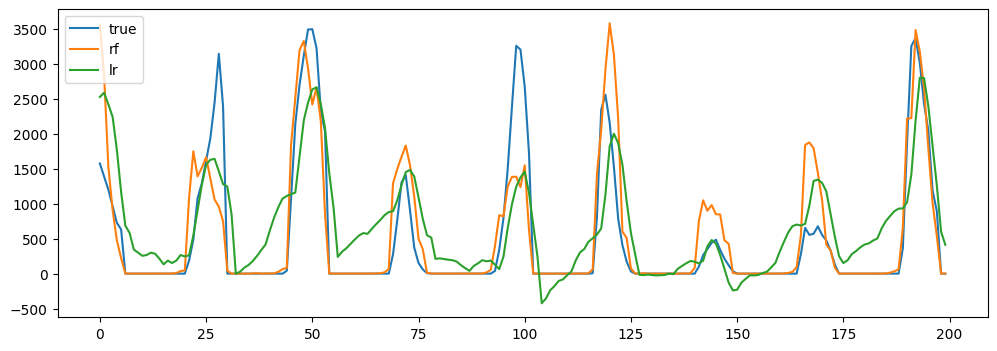

In [29]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))
plt.plot(y_test_s.values[:200], label="true")
plt.plot(y_pred_rf[:200], label="rf")
plt.plot(y_pred_lr[:200], label="lr")
plt.legend()
plt.show()

In [30]:
sorted(zip(feature_cols, best_rf.feature_importances_), key=lambda x: x[1], reverse=True)

[('Ground_Irradiance', np.float64(0.5965764581098184)),
 ('Solar_Power_lag1', np.float64(0.1617507979057815)),
 ('hour', np.float64(0.12387720316893217)),
 ('Solar_Power_lag24', np.float64(0.05154958749418772)),
 ('Atmospheric_Irradiance', np.float64(0.020821122850727448)),
 ('Temperature', np.float64(0.017796413432499148)),
 ('Air_Density', np.float64(0.006743412398669261)),
 ('Wind_Power_lag24', np.float64(0.004969530415703237)),
 ('Wind_Speed', np.float64(0.0040295129322397046)),
 ('Wind_Power_lag1', np.float64(0.0037185043508993175)),
 ('Humidity', np.float64(0.0028258660825086017)),
 ('dayofweek', np.float64(0.0026890090811491473)),
 ('month', np.float64(0.0026525817768844073))]

In [31]:
# Cell: XGBoost Implementation
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Define parameter grid (a small one to start)
xgb_param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [3, 6, 10],
    "learning_rate": [0.05, 0.1],
    "subsample": [0.8, 1.0],
    "colsample_bytree": [0.8, 1.0]
}

xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)

grid_xgb = GridSearchCV(
    xgb_model,
    param_grid=xgb_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_train, y_train_s)

best_xgb = grid_xgb.best_estimator_
print("Best XGB params:", grid_xgb.best_params_)

# Evaluate on test set
xgb_pred = best_xgb.predict(X_test)
xgb_metrics = evaluate_metrics(y_test_s, xgb_pred)
print("XGBoost ->", xgb_metrics)

# Save model
joblib.dump(best_xgb, "best_xgb_solar.joblib")

Fitting 3 folds for each of 48 candidates, totalling 144 fits
Best XGB params: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
XGBoost -> {'RMSE': np.float64(418.1856279973868), 'MAE': 247.07919107484435, 'SMAPE(%)': np.float64(148.48930042459125), 'R2': 0.8014737933510269}


['best_xgb_solar.joblib']

In [32]:
# Walk-forward evaluation for XGB
walk_xgb = walk_forward_eval(
    XGBRegressor(**grid_xgb.best_params_, objective="reg:squarederror", random_state=42),
    pd.concat([X_train, X_val, X_test]).reset_index(drop=True),
    pd.concat([y_train_s, y_val_s, y_test_s]).reset_index(drop=True),
    initial=int(0.5 * len(X_train)),  # size of first training window
    step=int(len(X_test) / 5) if len(X_test) >= 5 else 1  # expand window gradually
)

print("Walk-forward metrics for XGB:", walk_xgb)

Walk-forward metrics for XGB: {'RMSE': np.float64(367.8880170888832), 'MAE': 218.64487852814244, 'SMAPE(%)': np.float64(117.10509690702209), 'R2': 0.9134673156591961}


In [33]:
# Collect results into a DataFrame
results = pd.DataFrame([
    {"model": "Persistence", **persist_scores},
    {"model": "LinearRegression", **lr_scores},
    {"model": "RandomForest", **rf_scores},
    {"model": "XGBoost", **xgb_metrics}   # add XGBoost results
])

results

,model,RMSE,MAE,SMAPE(%),R2
0,Persistence,398.815722,184.756474,35.643015,0.819439
1,LinearRegression,570.667957,407.340272,150.150823,0.630302
2,RandomForest,432.085592,208.695939,113.221070,0.788057
3,XGBoost,418.185628,247.079191,148.489300,0.801474


In [34]:
# ---- Walk-forward results collection ----
results_walk = pd.DataFrame([
    {"model": "RandomForest", **walk_rf},
    {"model": "XGBoost", **walk_xgb}
    # Later you can also add walk-forward for LinearRegression or even Persistence if you implement it
])

# Display
print("Walk-forward results:")
results_walk

Walk-forward results:


,model,RMSE,MAE,SMAPE(%),R2
0,RandomForest,361.260492,193.485739,80.134947,0.916557
1,XGBoost,367.888017,218.644879,117.105097,0.913467


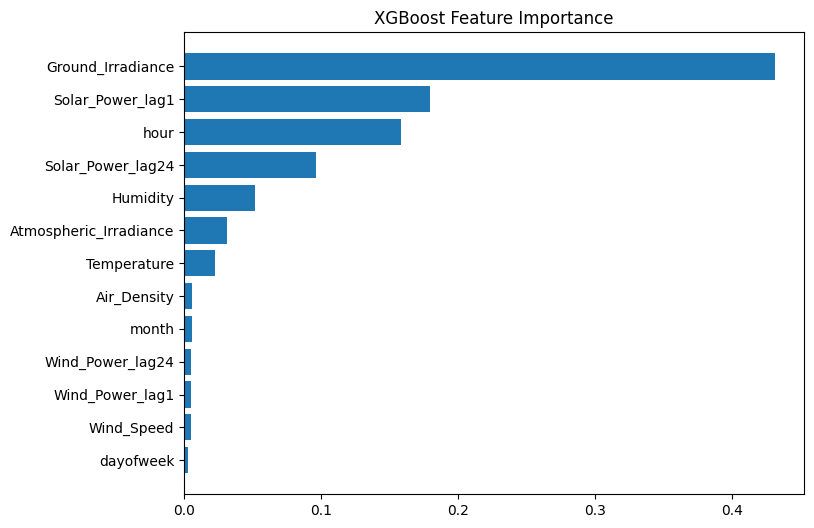

In [35]:
import matplotlib.pyplot as plt

xgb_importances = best_xgb.feature_importances_
feat_imp = pd.DataFrame({"Feature": X_train.columns, "Importance": xgb_importances})
feat_imp = feat_imp.sort_values("Importance", ascending=False)

plt.figure(figsize=(8,6))
plt.barh(feat_imp["Feature"], feat_imp["Importance"])
plt.gca().invert_yaxis()
plt.title("XGBoost Feature Importance")
plt.show()

In [36]:
# Merge static vs walk-forward into one summary
merged_results = results.set_index("model").join(
    results_walk.set_index("model"),
    lsuffix="_static", rsuffix="_walk"
)

merged_results

,RMSE_static,MAE_static,SMAPE(%)_static,R2_static,RMSE_walk,MAE_walk,SMAPE(%)_walk,R2_walk
model,,,,,,,,
Persistence,398.815722,184.756474,35.643015,0.819439,NaN,NaN,NaN,NaN
LinearRegression,570.667957,407.340272,150.150823,0.630302,NaN,NaN,NaN,NaN
RandomForest,432.085592,208.695939,113.221070,0.788057,361.260492,193.485739,80.134947,0.916557
XGBoost,418.185628,247.079191,148.489300,0.801474,367.888017,218.644879,117.105097,0.913467


In [37]:
from sklearn.svm import SVR

# Define pipeline: scaler then SVR
svr_pipeline = Pipeline([
    ("scaler", StandardScaler()),       # 1
    ("svr", SVR())                      # 2
])

# hyperparameter grid to search
svr_param_grid = {
    "svr__kernel": ["rbf", "poly"],     # 3
    "svr__C": [1.0, 10.0, 100.0],       # 4
    "svr__gamma": ["scale", "auto"]     # 5
}

# GridSearchCV with time-series-safe CV (use TimeSeriesSplit if needed)
grid_svr = GridSearchCV(
    estimator=svr_pipeline,             # 6
    param_grid=svr_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=3,                               # small CV for speed; use TimeSeriesSplit if desired
    n_jobs=-1,
    verbose=1
)

# Fit on training data only (like we did before)
grid_svr.fit(X_train, y_train_s)        # 7

# best model and prediction
best_svr = grid_svr.best_estimator_     # 8
y_pred_svr = best_svr.predict(X_test)   # 9

# Evaluate
svr_scores = evaluate_metrics(y_test_s.values, y_pred_svr)
print("SVR ->", svr_scores)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
SVR -> {'RMSE': np.float64(700.0891315275165), 'MAE': 547.2946022705589, 'SMAPE(%)': np.float64(152.85719275423727), 'R2': 0.443601040447716}


## **Deep Learning**

In [38]:
# CELL 1: imports, basic checks, reproducibility

# Deep learning imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Safety: ensure training splits exist; if not, try to rebuild from `merged_data` or `df`
try:
    X_train, X_val, X_test, y_train_s, y_val_s, y_test_s  # just test names exist
    print("Using existing X_train / X_val / X_test and y_train_s / y_val_s / y_test_s")
except NameError:
    # Try to recreate standard time split from `df` or `merged_data`
    if "df" in globals():
        _df = df.copy()
    elif "merged_data" in globals():
        _df = merged_data.copy()
    else:
        raise RuntimeError("No X_train found and no 'df' or 'merged_data' present. Load your cleaned DataFrame first.")
    # assume 'feature_cols' and targets exist
    if "feature_cols" not in globals():
        # choose defaults (adjust if you used different feature names)
        feature_cols = [c for c in _df.columns if c not in ("DateTime", "Solar_target", "Wind_target", "Solar_Power", "Wind_Power")]
    n = len(_df)
    train_end = int(0.70 * n)
    val_end = int(0.85 * n)
    X = _df[feature_cols]
    y_solar = _df["Solar_target"]
    X_train = X.iloc[:train_end].copy()
    X_val   = X.iloc[train_end:val_end].copy()
    X_test  = X.iloc[val_end:].copy()
    y_train_s = y_solar.iloc[:train_end].copy()
    y_val_s   = y_solar.iloc[train_end:val_end].copy()
    y_test_s  = y_solar.iloc[val_end:].copy()
    print("Recreated train/val/test splits from dataframe. Shapes:", X_train.shape, X_val.shape, X_test.shape)

# Set seeds for reproducibility (helps but does not guarantee identical DL runs)
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

Using existing X_train / X_val / X_test and y_train_s / y_val_s / y_test_s


In [39]:
# CELL 2: Fit MinMax scalers for features and target (train-only)
feature_cols = list(X_train.columns)  # explicit list of feature column names

# Feature scaler: fit on X_train only
feature_scaler = MinMaxScaler()
feature_scaler.fit(X_train[feature_cols])

# Target scaler: fit on y_train_s only (reshape to 2D required)
target_scaler = MinMaxScaler()
target_scaler.fit(y_train_s.values.reshape(-1, 1))

# Save scalers so you can reload later
joblib.dump(feature_scaler, "feature_scaler.joblib")
joblib.dump(target_scaler, "target_scaler.joblib")

# Transform train/val/test features and targets
X_train_s = pd.DataFrame(feature_scaler.transform(X_train[feature_cols]), columns=feature_cols, index=X_train.index)
X_val_s   = pd.DataFrame(feature_scaler.transform(X_val[feature_cols]),   columns=feature_cols, index=X_val.index)
X_test_s  = pd.DataFrame(feature_scaler.transform(X_test[feature_cols]),  columns=feature_cols, index=X_test.index)

y_train_s_scaled = target_scaler.transform(y_train_s.values.reshape(-1,1)).flatten()
y_val_s_scaled   = target_scaler.transform(y_val_s.values.reshape(-1,1)).flatten()
y_test_s_scaled  = target_scaler.transform(y_test_s.values.reshape(-1,1)).flatten()

print("Feature scaler fitted. Feature sample (train):")
display(X_train_s.head())

Feature scaler fitted. Feature sample (train):


,Temperature,Humidity,Ground_Irradiance,Atmospheric_Irradiance,Air_Density,Wind_Speed,Solar_Power_lag1,Solar_Power_lag24,Wind_Power_lag1,Wind_Power_lag24,hour,dayofweek,month
0,0.189456,0.052632,0.118687,0.176241,0.792388,0.104728,0.048462,0.057264,0.002420,0.242870,0.347826,0.333333,0.0
1,0.225571,0.052632,0.239731,0.290260,0.802768,0.153663,0.331661,0.117865,0.002454,0.284555,0.391304,0.333333,0.0
2,0.257932,0.052632,0.329584,0.361375,0.813149,0.215482,0.679224,0.193559,0.017956,0.312240,0.434783,0.333333,0.0
3,0.279778,0.052632,0.359166,0.384702,0.820069,0.253304,0.776142,0.241623,0.067739,0.313942,0.478261,0.333333,0.0
4,0.292028,0.052632,0.329195,0.358657,0.826990,0.275090,0.777745,0.224480,0.113424,0.293902,0.521739,0.333333,0.0


In [40]:
# CELL 3: sequence builder and sequence splits
import numpy as np

def create_sequences(X_df, y_arr, window_size):
    """
    Build sequences for DL:
    - X_df: pandas DataFrame of scaled features ordered by time
    - y_arr: 1D numpy array of scaled target aligned with X_df
    - window_size: number of past steps to include (e.g., 24)
    returns X_seq (n_samples, window_size, n_features), y_seq (n_samples,)
    """
    X = X_df.values
    y = np.array(y_arr)
    n_samples = len(X) - window_size
    Xs, ys = [], []
    for i in range(n_samples):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

# Build full sequences from concatenated scaled sets
X_full_s = pd.concat([X_train_s, X_val_s, X_test_s]).reset_index(drop=True)
y_full_s = np.concatenate([y_train_s_scaled, y_val_s_scaled, y_test_s_scaled])

window = 24  # lookback window (24 hours)
X_seq_full, y_seq_full = create_sequences(X_full_s, y_full_s, window)

# split back into train/val/test sequences by proportion (consistent with original)
n_total_seq = len(X_seq_full)
train_end_idx = int(0.70 * n_total_seq)
val_end_idx   = int(0.85 * n_total_seq)

X_train_seq = X_seq_full[:train_end_idx]
X_val_seq   = X_seq_full[train_end_idx:val_end_idx]
X_test_seq  = X_seq_full[val_end_idx:]

y_train_seq = y_seq_full[:train_end_idx]
y_val_seq   = y_seq_full[train_end_idx:val_end_idx]
y_test_seq  = y_seq_full[val_end_idx:]

print("Sequence shapes -> X_train_seq:", X_train_seq.shape, "X_val_seq:", X_val_seq.shape, "X_test_seq:", X_test_seq.shape)

Sequence shapes -> X_train_seq: (6092, 24, 13) X_val_seq: (1305, 24, 13) X_test_seq: (1306, 24, 13)


In [42]:
# Use the sequences you already built
n_total = len(X_seq_full)
train_end_idx = int(0.70 * n_total)
val_end_idx   = int(0.85 * n_total)

X_train_seq = X_seq_full[:train_end_idx]
X_val_seq   = X_seq_full[train_end_idx:val_end_idx]
X_test_seq  = X_seq_full[val_end_idx:]

y_train_seq = y_seq_full[:train_end_idx]
y_val_seq   = y_seq_full[train_end_idx:val_end_idx]
y_test_seq  = y_seq_full[val_end_idx:]

print("Sequence shapes ->",
      "X_train_seq:", X_train_seq.shape,
      "X_val_seq:", X_val_seq.shape,
      "X_test_seq:", X_test_seq.shape)

Sequence shapes -> X_train_seq: (6092, 24, 13) X_val_seq: (1305, 24, 13) X_test_seq: (1306, 24, 13)


In [43]:
# CELL 5: LSTM model training + evaluation (end-to-end)

# model definition
n_timesteps = X_train_seq.shape[1]
n_features  = X_train_seq.shape[2]

model_lstm = Sequential([
    LSTM(64, input_shape=(n_timesteps, n_features), return_sequences=False),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

model_lstm.compile(optimizer="adam", loss="mse", metrics=["mae"])

# callbacks: early stop + save best (Keras native format .keras avoids HDF5 warning)
es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
ckpt = ModelCheckpoint("best_lstm_model.keras", save_best_only=True, monitor="val_loss")

# Train
history_lstm = model_lstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[es, ckpt],
    verbose=2
)

# Load best model (optional but safe)
model_lstm = tf.keras.models.load_model("best_lstm_model.keras")

# Predict (scaled), inverse-transform to original units
y_pred_scaled = model_lstm.predict(X_test_seq).flatten()
y_pred = target_scaler.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
y_true = target_scaler.inverse_transform(y_test_seq.reshape(-1,1)).flatten()

# Evaluate in original units
lstm_scores = evaluate_metrics(y_true, y_pred)
print("LSTM ->", lstm_scores)

# Save model explicitly
model_lstm.save("final_lstm_model.keras")

Epoch 1/50
191/191 - 7s - 34ms/step - loss: 0.0429 - mae: 0.1516 - val_loss: 0.0256 - val_mae: 0.1180
Epoch 2/50
191/191 - 3s - 14ms/step - loss: 0.0205 - mae: 0.0983 - val_loss: 0.0246 - val_mae: 0.1147
Epoch 3/50
191/191 - 3s - 13ms/step - loss: 0.0174 - mae: 0.0885 - val_loss: 0.0236 - val_mae: 0.1122
Epoch 4/50
191/191 - 3s - 13ms/step - loss: 0.0161 - mae: 0.0830 - val_loss: 0.0237 - val_mae: 0.1113
Epoch 5/50
191/191 - 3s - 15ms/step - loss: 0.0149 - mae: 0.0784 - val_loss: 0.0243 - val_mae: 0.1122
Epoch 6/50
191/191 - 3s - 16ms/step - loss: 0.0146 - mae: 0.0777 - val_loss: 0.0251 - val_mae: 0.1142
Epoch 7/50
191/191 - 5s - 24ms/step - loss: 0.0134 - mae: 0.0735 - val_loss: 0.0230 - val_mae: 0.1064
Epoch 8/50
191/191 - 3s - 13ms/step - loss: 0.0135 - mae: 0.0736 - val_loss: 0.0233 - val_mae: 0.1084
Epoch 9/50
191/191 - 6s - 29ms/step - loss: 0.0127 - mae: 0.0710 - val_loss: 0.0216 - val_mae: 0.1015
Epoch 10/50
191/191 - 3s - 13ms/step - loss: 0.0124 - mae: 0.0696 - val_loss: 0.02

In [44]:
# CELL 6: GRU training + eval (same pipeline as LSTM)
from tensorflow.keras.layers import GRU

model_gru = Sequential([
    GRU(64, input_shape=(n_timesteps, n_features)),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

model_gru.compile(optimizer="adam", loss="mse", metrics=["mae"])

es_gru = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
ckpt_gru = ModelCheckpoint("best_gru_model.keras", save_best_only=True, monitor="val_loss")

history_gru = model_gru.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[es_gru, ckpt_gru],
    verbose=2
)

model_gru = tf.keras.models.load_model("best_gru_model.keras")

y_pred_scaled_gru = model_gru.predict(X_test_seq).flatten()
y_pred_gru = target_scaler.inverse_transform(y_pred_scaled_gru.reshape(-1,1)).flatten()
y_true = target_scaler.inverse_transform(y_test_seq.reshape(-1,1)).flatten()

gru_scores = evaluate_metrics(y_true, y_pred_gru)
print("GRU ->", gru_scores)
model_gru.save("final_gru_model.keras")

Epoch 1/50
191/191 - 6s - 31ms/step - loss: 0.0328 - mae: 0.1337 - val_loss: 0.0304 - val_mae: 0.1385
Epoch 2/50
191/191 - 3s - 15ms/step - loss: 0.0195 - mae: 0.0964 - val_loss: 0.0246 - val_mae: 0.1102
Epoch 3/50
191/191 - 4s - 21ms/step - loss: 0.0169 - mae: 0.0867 - val_loss: 0.0222 - val_mae: 0.1037
Epoch 4/50
191/191 - 3s - 15ms/step - loss: 0.0150 - mae: 0.0810 - val_loss: 0.0240 - val_mae: 0.1086
Epoch 5/50
191/191 - 3s - 15ms/step - loss: 0.0139 - mae: 0.0772 - val_loss: 0.0258 - val_mae: 0.1096
Epoch 6/50
191/191 - 3s - 15ms/step - loss: 0.0132 - mae: 0.0751 - val_loss: 0.0261 - val_mae: 0.1125
Epoch 7/50
191/191 - 4s - 21ms/step - loss: 0.0128 - mae: 0.0733 - val_loss: 0.0226 - val_mae: 0.1070
Epoch 8/50
191/191 - 3s - 15ms/step - loss: 0.0125 - mae: 0.0724 - val_loss: 0.0238 - val_mae: 0.1082
Epoch 9/50
191/191 - 5s - 27ms/step - loss: 0.0121 - mae: 0.0709 - val_loss: 0.0215 - val_mae: 0.1024
Epoch 10/50
191/191 - 5s - 29ms/step - loss: 0.0116 - mae: 0.0692 - val_loss: 0.02

In [45]:
# CELL 7: Bidirectional LSTM training + eval
from tensorflow.keras.layers import Bidirectional

model_bilstm = Sequential([
    Bidirectional(LSTM(64), input_shape=(n_timesteps, n_features)),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

model_bilstm.compile(optimizer="adam", loss="mse", metrics=["mae"])

es_bi = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
ckpt_bi = ModelCheckpoint("best_bilstm_model.keras", save_best_only=True, monitor="val_loss")

history_bi = model_bilstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=50,
    batch_size=32,
    callbacks=[es_bi, ckpt_bi],
    verbose=2
)

model_bilstm = tf.keras.models.load_model("best_bilstm_model.keras")

y_pred_scaled_bi = model_bilstm.predict(X_test_seq).flatten()
y_pred_bi = target_scaler.inverse_transform(y_pred_scaled_bi.reshape(-1,1)).flatten()
y_true = target_scaler.inverse_transform(y_test_seq.reshape(-1,1)).flatten()

bilstm_scores = evaluate_metrics(y_true, y_pred_bi)
print("Bi-LSTM ->", bilstm_scores)
model_bilstm.save("final_bilstm_model.keras")

Epoch 1/50
191/191 - 10s - 54ms/step - loss: 0.0308 - mae: 0.1245 - val_loss: 0.0213 - val_mae: 0.1010
Epoch 2/50
191/191 - 9s - 47ms/step - loss: 0.0193 - mae: 0.0927 - val_loss: 0.0171 - val_mae: 0.0868
Epoch 3/50
191/191 - 4s - 20ms/step - loss: 0.0164 - mae: 0.0827 - val_loss: 0.0159 - val_mae: 0.0797
Epoch 4/50
191/191 - 4s - 20ms/step - loss: 0.0148 - mae: 0.0774 - val_loss: 0.0158 - val_mae: 0.0814
Epoch 5/50
191/191 - 5s - 27ms/step - loss: 0.0141 - mae: 0.0743 - val_loss: 0.0152 - val_mae: 0.0778
Epoch 6/50
191/191 - 4s - 20ms/step - loss: 0.0133 - mae: 0.0713 - val_loss: 0.0158 - val_mae: 0.0787
Epoch 7/50
191/191 - 4s - 23ms/step - loss: 0.0126 - mae: 0.0689 - val_loss: 0.0149 - val_mae: 0.0768
Epoch 8/50
191/191 - 6s - 30ms/step - loss: 0.0125 - mae: 0.0684 - val_loss: 0.0162 - val_mae: 0.0797
Epoch 9/50
191/191 - 4s - 20ms/step - loss: 0.0120 - mae: 0.0667 - val_loss: 0.0159 - val_mae: 0.0778
Epoch 10/50
191/191 - 4s - 20ms/step - loss: 0.0114 - mae: 0.0647 - val_loss: 0.0

,model,RMSE,MAE,SMAPE(%),R2
0,LSTM,1327.237004,734.618179,153.939302,-0.998319
1,GRU,1242.263876,776.464113,155.494929,-0.750635
2,BiLSTM,734.335948,529.173348,154.947649,0.388273


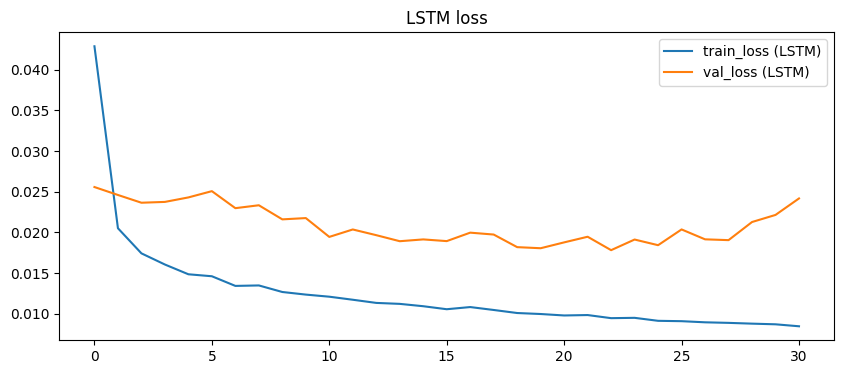

In [46]:
# CELL 8: Compare static metrics from DL models
results_dl = pd.DataFrame([
    {"model": "LSTM", "RMSE": lstm_scores["RMSE"], "MAE": lstm_scores["MAE"], "SMAPE(%)": lstm_scores["SMAPE(%)"], "R2": lstm_scores["R2"]},
    {"model": "GRU", "RMSE": gru_scores["RMSE"],  "MAE": gru_scores["MAE"],  "SMAPE(%)": gru_scores["SMAPE(%)"],  "R2": gru_scores["R2"]},
    {"model": "BiLSTM", "RMSE": bilstm_scores["RMSE"], "MAE": bilstm_scores["MAE"], "SMAPE(%)": bilstm_scores["SMAPE(%)"], "R2": bilstm_scores["R2"]}
])
display(results_dl)

# Plot training histories (example LSTM)
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(history_lstm.history["loss"], label="train_loss (LSTM)")
plt.plot(history_lstm.history["val_loss"], label="val_loss (LSTM)")
plt.legend()
plt.title("LSTM loss")
plt.show()

In [48]:
!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 10.9 MB/s eta 0:00:00


In [49]:
# CELL 2: Objective function for XGBoost
def objective_xgb(trial):
    # Search space
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [100, 200, 400]),
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.01, 0.2),
        "subsample": trial.suggest_uniform("subsample", 0.6, 1.0),
        "colsample_bytree": trial.suggest_uniform("colsample_bytree", 0.6, 1.0),
    }

    tscv = TimeSeriesSplit(n_splits=3)  # 3 folds for speed
    rmse_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val_ = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val_ = y_train_s.iloc[train_idx], y_train_s.iloc[val_idx]

        model = XGBRegressor(objective="reg:squarederror", random_state=42, **params)
        model.fit(X_tr, y_tr)

        preds = model.predict(X_val_)
        rmse_scores.append(np.sqrt(mean_squared_error(y_val_, preds)))

    return np.mean(rmse_scores)  # Optuna minimizes this


# CELL 3: Run Optuna for XGB
study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=30)  # 30 trials (increase for more thorough search)

print("Best params (XGB):", study_xgb.best_params)
print("Best RMSE:", study_xgb.best_value)

# Train final best model
best_xgb = XGBRegressor(objective="reg:squarederror", random_state=42, **study_xgb.best_params)
best_xgb.fit(X_train, y_train_s)

# Evaluate on test
y_pred_xgb_opt = best_xgb.predict(X_test)
xgb_opt_scores = evaluate_metrics(y_test_s, y_pred_xgb_opt)
print("Optuna-tuned XGB ->", xgb_opt_scores)

[I 2025-09-15 04:06:07,343] A new study created in memory with name: no-name-e7fa05f3-129f-458d-a30c-247816f52221
[I 2025-09-15 04:06:15,365] Trial 0 finished with value: 439.6607632105847 and parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.0930431683468399, 'subsample': 0.9909165059003017, 'colsample_bytree': 0.8425737904372623}. Best is trial 0 with value: 439.6607632105847.
[I 2025-09-15 04:06:19,754] Trial 1 finished with value: 428.3861162756097 and parameters: {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.07756314599389488, 'subsample': 0.9788375434767438, 'colsample_bytree': 0.8000718683931174}. Best is trial 1 with value: 428.3861162756097.
[I 2025-09-15 04:06:51,071] Trial 2 finished with value: 555.4158399471684 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.019193516917570663, 'subsample': 0.8199225381491868, 'colsample_bytree': 0.6512483356620183}. Best is trial 1 with value: 428.3861162756097.
[I 2025-09-15 04:07:0

Best params (XGB): {'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.07756314599389488, 'subsample': 0.9788375434767438, 'colsample_bytree': 0.8000718683931174}
Best RMSE: 428.3861162756097
Optuna-tuned XGB -> {'RMSE': np.float64(399.5541188130392), 'MAE': 221.2573233649494, 'SMAPE(%)': np.float64(146.88987385482915), 'R2': 0.8187696780124922}


In [50]:
# CELL 4: Objective for RandomForest
def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_categorical("n_estimators", [100, 200, 400]),
        "max_depth": trial.suggest_int("max_depth", 5, 30),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
    }

    tscv = TimeSeriesSplit(n_splits=3)
    rmse_scores = []

    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val_ = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val_ = y_train_s.iloc[train_idx], y_train_s.iloc[val_idx]

        model = RandomForestRegressor(random_state=42, n_jobs=-1, **params)
        model.fit(X_tr, y_tr)

        preds = model.predict(X_val_)
        rmse_scores.append(np.sqrt(mean_squared_error(y_val_, preds)))

    return np.mean(rmse_scores)

study_rf = optuna.create_study(direction="minimize")
study_rf.optimize(objective_rf, n_trials=30)

print("Best params (RF):", study_rf.best_params)
print("Best RMSE:", study_rf.best_value)

# Train and evaluate best RF
best_rf_opt = RandomForestRegressor(random_state=42, n_jobs=-1, **study_rf.best_params)
best_rf_opt.fit(X_train, y_train_s)
y_pred_rf_opt = best_rf_opt.predict(X_test)
rf_opt_scores = evaluate_metrics(y_test_s, y_pred_rf_opt)
print("Optuna-tuned RF ->", rf_opt_scores)

[I 2025-09-15 04:07:48,678] A new study created in memory with name: no-name-90ffbbc6-524e-4086-b283-86ed38671d44
[I 2025-09-15 04:07:53,200] Trial 0 finished with value: 418.5601183193371 and parameters: {'n_estimators': 100, 'max_depth': 28, 'min_samples_leaf': 5}. Best is trial 0 with value: 418.5601183193371.
[I 2025-09-15 04:08:15,175] Trial 1 finished with value: 415.2231775020768 and parameters: {'n_estimators': 400, 'max_depth': 21, 'min_samples_leaf': 5}. Best is trial 1 with value: 415.2231775020768.
[I 2025-09-15 04:08:39,775] Trial 2 finished with value: 419.22792452029506 and parameters: {'n_estimators': 400, 'max_depth': 17, 'min_samples_leaf': 2}. Best is trial 1 with value: 415.2231775020768.
[I 2025-09-15 04:09:00,258] Trial 3 finished with value: 419.67857848679677 and parameters: {'n_estimators': 400, 'max_depth': 10, 'min_samples_leaf': 2}. Best is trial 1 with value: 415.2231775020768.
[I 2025-09-15 04:09:22,358] Trial 4 finished with value: 416.20036510429264 and 

Best params (RF): {'n_estimators': 200, 'max_depth': 11, 'min_samples_leaf': 4}
Best RMSE: 414.74976094566756
Optuna-tuned RF -> {'RMSE': np.float64(429.6222569544137), 'MAE': 206.70490143156357, 'SMAPE(%)': np.float64(144.00814523530644), 'R2': 0.7904666373701607}


In [51]:
def objective_lstm(trial):
    """
    Optuna objective for tuning LSTM hyperparameters.
    Builds, trains, and evaluates a small LSTM.
    """
    # --- Hyperparameters to tune ---
    n_units = trial.suggest_int("units", 32, 128, step=32)    # number of LSTM units
    dropout = trial.suggest_uniform("dropout", 0.1, 0.5)      # dropout %
    dense_units = trial.suggest_int("dense_units", 16, 64, step=16) # dense layer size
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)           # learning rate
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = 30   # keep short for Optuna speed (final model can train longer)

    # --- Build model ---
    model = Sequential([
        LSTM(n_units, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        Dropout(dropout),
        Dense(dense_units, activation="relu"),
        Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

    # --- Early stopping ---
    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    # --- Train ---
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=0
    )

    # --- Evaluate on validation ---
    val_loss = model.evaluate(X_val_seq, y_val_seq, verbose=0)[0]  # return MSE
    return val_loss

study_lstm = optuna.create_study(direction="minimize")
study_lstm.optimize(objective_lstm, n_trials=10)   # try 10 trials first

print("Best LSTM params:", study_lstm.best_params)

[I 2025-09-15 04:13:40,986] A new study created in memory with name: no-name-45a241d5-fdad-400e-8f66-39c99003e7f7
[I 2025-09-15 04:14:21,623] Trial 0 finished with value: 0.02154766023159027 and parameters: {'units': 96, 'dropout': 0.15418147704987192, 'dense_units': 48, 'lr': 0.000774271809922028, 'batch_size': 32}. Best is trial 0 with value: 0.02154766023159027.
[I 2025-09-15 04:15:31,373] Trial 1 finished with value: 0.019700249657034874 and parameters: {'units': 64, 'dropout': 0.1538932549935956, 'dense_units': 32, 'lr': 0.0005766297579056918, 'batch_size': 16}. Best is trial 1 with value: 0.019700249657034874.
[I 2025-09-15 04:17:05,255] Trial 2 finished with value: 0.0149016622453928 and parameters: {'units': 64, 'dropout': 0.2969807576418362, 'dense_units': 32, 'lr': 0.00038674347321991914, 'batch_size': 32}. Best is trial 2 with value: 0.0149016622453928.
[I 2025-09-15 04:17:51,969] Trial 3 finished with value: 0.015710188075900078 and parameters: {'units': 96, 'dropout': 0.33

Best LSTM params: {'units': 64, 'dropout': 0.2969807576418362, 'dense_units': 32, 'lr': 0.00038674347321991914, 'batch_size': 32}


In [52]:
best_params = study_lstm.best_params

model_lstm = Sequential([
    LSTM(best_params["units"], input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(best_params["dropout"]),
    Dense(best_params["dense_units"], activation="relu"),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=best_params["lr"])
model_lstm.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

history = model_lstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,   # longer training for final model
    batch_size=best_params["batch_size"],
    callbacks=[es],
    verbose=2
)

# Predictions
y_pred_lstm = model_lstm.predict(X_test_seq).flatten()

# Evaluate with your custom metrics
lstm_scores = evaluate_metrics(y_test_seq, y_pred_lstm)
print("LSTM (Optuna best) ->", lstm_scores)

Epoch 1/100
191/191 - 6s - 33ms/step - loss: 0.0468 - mae: 0.1638 - val_loss: 0.0326 - val_mae: 0.1374
Epoch 2/100
191/191 - 4s - 23ms/step - loss: 0.0258 - mae: 0.1134 - val_loss: 0.0257 - val_mae: 0.1148
Epoch 3/100
191/191 - 3s - 13ms/step - loss: 0.0209 - mae: 0.0996 - val_loss: 0.0234 - val_mae: 0.1077
Epoch 4/100
191/191 - 4s - 19ms/step - loss: 0.0193 - mae: 0.0932 - val_loss: 0.0247 - val_mae: 0.1098
Epoch 5/100
191/191 - 4s - 21ms/step - loss: 0.0186 - mae: 0.0900 - val_loss: 0.0260 - val_mae: 0.1105
Epoch 6/100
191/191 - 3s - 13ms/step - loss: 0.0169 - mae: 0.0850 - val_loss: 0.0250 - val_mae: 0.1118
Epoch 7/100
191/191 - 3s - 13ms/step - loss: 0.0163 - mae: 0.0826 - val_loss: 0.0237 - val_mae: 0.1038
Epoch 8/100
191/191 - 4s - 19ms/step - loss: 0.0161 - mae: 0.0816 - val_loss: 0.0265 - val_mae: 0.1134
Epoch 9/100
191/191 - 4s - 21ms/step - loss: 0.0152 - mae: 0.0792 - val_loss: 0.0247 - val_mae: 0.1077
Epoch 10/100
191/191 - 3s - 14ms/step - loss: 0.0147 - mae: 0.0767 - val_

In [53]:
def objective_gru(trial):
    n_units = trial.suggest_int("units", 32, 128, step=32)
    dropout = trial.suggest_uniform("dropout", 0.1, 0.5)
    dense_units = trial.suggest_int("dense_units", 16, 64, step=16)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = 30

    model = Sequential([
        GRU(n_units, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        Dropout(dropout),
        Dense(dense_units, activation="relu"),
        Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=0
    )

    val_loss = model.evaluate(X_val_seq, y_val_seq, verbose=0)[0]
    return val_loss

study_gru = optuna.create_study(direction="minimize")
study_gru.optimize(objective_gru, n_trials=10)

print("Best GRU params:", study_gru.best_params)

[I 2025-09-15 04:25:16,921] A new study created in memory with name: no-name-2a4b451a-2688-4eb1-86fb-3a0544ba3cf9
[I 2025-09-15 04:25:54,021] Trial 0 finished with value: 0.020113272592425346 and parameters: {'units': 64, 'dropout': 0.23971002046119227, 'dense_units': 64, 'lr': 0.0012990607370557065, 'batch_size': 32}. Best is trial 0 with value: 0.020113272592425346.
[I 2025-09-15 04:26:24,412] Trial 1 finished with value: 0.020242078229784966 and parameters: {'units': 64, 'dropout': 0.11012360153572782, 'dense_units': 16, 'lr': 0.00785192075678563, 'batch_size': 64}. Best is trial 0 with value: 0.020113272592425346.
[I 2025-09-15 04:27:21,775] Trial 2 finished with value: 0.019909264519810677 and parameters: {'units': 64, 'dropout': 0.22673500034581934, 'dense_units': 64, 'lr': 0.000307406286303109, 'batch_size': 32}. Best is trial 2 with value: 0.019909264519810677.
[I 2025-09-15 04:27:52,444] Trial 3 finished with value: 0.01712122932076454 and parameters: {'units': 32, 'dropout': 

Best GRU params: {'units': 64, 'dropout': 0.24180895908035716, 'dense_units': 48, 'lr': 0.00488377448151618, 'batch_size': 64}


In [54]:
from tensorflow.keras.layers import Bidirectional

def objective_bilstm(trial):
    """
    Optuna objective for tuning Bidirectional LSTM.
    """
    # --- Hyperparameters to tune ---
    n_units = trial.suggest_int("units", 32, 128, step=32)
    dropout = trial.suggest_uniform("dropout", 0.1, 0.5)
    dense_units = trial.suggest_int("dense_units", 16, 64, step=16)
    lr = trial.suggest_loguniform("lr", 1e-4, 1e-2)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    epochs = 30   # shorter for Optuna, longer later

    # --- Build model ---
    model = Sequential([
        Bidirectional(LSTM(n_units), input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
        Dropout(dropout),
        Dense(dense_units, activation="relu"),
        Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

    es = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    # --- Train ---
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[es],
        verbose=0
    )

    # --- Evaluate on validation ---
    val_loss = model.evaluate(X_val_seq, y_val_seq, verbose=0)[0]
    return val_loss

study_bilstm = optuna.create_study(direction="minimize")
study_bilstm.optimize(objective_bilstm, n_trials=10)   # start with 10 trials

print("Best BiLSTM params:", study_bilstm.best_params)

[I 2025-09-15 04:33:18,385] A new study created in memory with name: no-name-0cf4b521-6968-485f-9aa3-feb262bb975d
[I 2025-09-15 04:34:39,338] Trial 0 finished with value: 0.01235132198780775 and parameters: {'units': 32, 'dropout': 0.40717306451633106, 'dense_units': 16, 'lr': 0.0008868421618704204, 'batch_size': 64}. Best is trial 0 with value: 0.01235132198780775.
[I 2025-09-15 04:35:32,799] Trial 1 finished with value: 0.012605475261807442 and parameters: {'units': 32, 'dropout': 0.1709319864595633, 'dense_units': 64, 'lr': 0.006065863781335883, 'batch_size': 32}. Best is trial 0 with value: 0.01235132198780775.
[I 2025-09-15 04:38:40,582] Trial 2 finished with value: 0.01263121422380209 and parameters: {'units': 96, 'dropout': 0.3344300697613011, 'dense_units': 16, 'lr': 0.0010570996417141993, 'batch_size': 16}. Best is trial 0 with value: 0.01235132198780775.
[I 2025-09-15 04:40:03,706] Trial 3 finished with value: 0.013875465840101242 and parameters: {'units': 64, 'dropout': 0.48

Best BiLSTM params: {'units': 128, 'dropout': 0.11447478607013793, 'dense_units': 32, 'lr': 0.009764518139371011, 'batch_size': 32}


In [55]:
best_params_bilstm = study_bilstm.best_params

model_bilstm = Sequential([
    Bidirectional(LSTM(best_params_bilstm["units"]), input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])),
    Dropout(best_params_bilstm["dropout"]),
    Dense(best_params_bilstm["dense_units"], activation="relu"),
    Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=best_params_bilstm["lr"])
model_bilstm.compile(optimizer=optimizer, loss="mse", metrics=["mae"])

es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)

history_bilstm = model_bilstm.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=100,   # longer final training
    batch_size=best_params_bilstm["batch_size"],
    callbacks=[es],
    verbose=2
)

# Predictions
y_pred_bilstm = model_bilstm.predict(X_test_seq).flatten()

# Evaluate
bilstm_scores = evaluate_metrics(y_test_seq, y_pred_bilstm)
print("BiLSTM (Optuna best) ->", bilstm_scores)

Epoch 1/100
191/191 - 16s - 81ms/step - loss: 0.0433 - mae: 0.1252 - val_loss: 0.0233 - val_mae: 0.1054
Epoch 2/100
191/191 - 11s - 58ms/step - loss: 0.0157 - mae: 0.0825 - val_loss: 0.0136 - val_mae: 0.0795
Epoch 3/100
191/191 - 20s - 103ms/step - loss: 0.0132 - mae: 0.0729 - val_loss: 0.0133 - val_mae: 0.0712
Epoch 4/100
191/191 - 24s - 125ms/step - loss: 0.0125 - mae: 0.0689 - val_loss: 0.0137 - val_mae: 0.0736
Epoch 5/100
191/191 - 11s - 59ms/step - loss: 0.0125 - mae: 0.0691 - val_loss: 0.0145 - val_mae: 0.0811
Epoch 6/100
191/191 - 12s - 62ms/step - loss: 0.0120 - mae: 0.0673 - val_loss: 0.0151 - val_mae: 0.0806
Epoch 7/100
191/191 - 21s - 107ms/step - loss: 0.0112 - mae: 0.0656 - val_loss: 0.0138 - val_mae: 0.0782
Epoch 8/100
191/191 - 20s - 103ms/step - loss: 0.0113 - mae: 0.0668 - val_loss: 0.0113 - val_mae: 0.0629
Epoch 9/100
191/191 - 12s - 61ms/step - loss: 0.0110 - mae: 0.0650 - val_loss: 0.0152 - val_mae: 0.0757
Epoch 10/100
191/191 - 12s - 62ms/step - loss: 0.0108 - mae:

## **ML for Wind**

In [56]:
# Wind targets
y_train_w = y_wind.iloc[:train_end].copy()
y_val_w   = y_wind.iloc[train_end:val_end].copy()
y_test_w  = y_wind.iloc[val_end:].copy()

# Persistence: next step ≈ last observed Wind_Power
if "Wind_Power" in X_test.columns:
    y_pred_persist_w = X_test["Wind_Power"]
else:
    y_pred_persist_w = df["Wind_Power"].iloc[val_end:val_end+len(X_test)].reset_index(drop=True)

persist_scores_w = evaluate_metrics(y_test_w.values, y_pred_persist_w.values)
print("Persistence baseline (Wind) ->", persist_scores_w)

Persistence baseline (Wind) -> {'RMSE': np.float64(247.8914322335116), 'MAE': 162.91976030534352, 'SMAPE(%)': np.float64(26.24444663165979), 'R2': 0.9459897333244991}


In [58]:
lr_pipeline_w = Pipeline([
    ("scaler", StandardScaler()),
    ("lr", LinearRegression())
])

lr_pipeline_w.fit(X_train, y_train_w)
y_pred_lr_w = lr_pipeline_w.predict(X_test)

lr_scores_w = evaluate_metrics(y_test_w.values, y_pred_lr_w)
print("Linear Regression (Wind) ->", lr_scores_w)

Linear Regression (Wind) -> {'RMSE': np.float64(366.27034486835595), 'MAE': 269.5837639271422, 'SMAPE(%)': np.float64(50.81280530319431), 'R2': 0.8820883265817653}


In [59]:
gsearch_rf_w = GridSearchCV(
    estimator=rf,   # same rf object you defined before
    param_grid=param_grid,
    cv=tscv,
    scoring="neg_root_mean_squared_error",
    n_jobs=-1,
    verbose=1
)

gsearch_rf_w.fit(X_train, y_train_w)
best_rf_w = gsearch_rf_w.best_estimator_

y_pred_rf_w = best_rf_w.predict(X_test)
rf_scores_w = evaluate_metrics(y_test_w.values, y_pred_rf_w)
print("Random Forest (Wind) ->", rf_scores_w)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Random Forest (Wind) -> {'RMSE': np.float64(189.94988267177078), 'MAE': 126.59732881814361, 'SMAPE(%)': np.float64(23.510252116580503), 'R2': 0.9682874366709875}


In [60]:
grid_xgb_w = GridSearchCV(
    estimator=xgb_model,     # same base XGBRegressor you used before
    param_grid=xgb_param_grid,
    scoring="neg_root_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_xgb_w.fit(X_train, y_train_w)
best_xgb_w = grid_xgb_w.best_estimator_

y_pred_xgb_w = best_xgb_w.predict(X_test)
xgb_scores_w = evaluate_metrics(y_test_w.values, y_pred_xgb_w)
print("XGBoost (Wind) ->", xgb_scores_w)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
XGBoost (Wind) -> {'RMSE': np.float64(196.86440677366127), 'MAE': 135.7550660370823, 'SMAPE(%)': np.float64(27.26391040017477), 'R2': 0.9659366236252531}


In [61]:
results_wind_ml = pd.DataFrame([
    {"model": "Persistence", **persist_scores_w},
    {"model": "LinearRegression", **lr_scores_w},
    {"model": "RandomForest", **rf_scores_w},
    {"model": "XGBoost", **xgb_scores_w}
])

print("Wind ML Results:")
display(results_wind_ml)

Wind ML Results:


,model,RMSE,MAE,SMAPE(%),R2
0,Persistence,247.891432,162.919760,26.244447,0.945990
1,LinearRegression,366.270345,269.583764,50.812805,0.882088
2,RandomForest,189.949883,126.597329,23.510252,0.968287
3,XGBoost,196.864407,135.755066,27.263910,0.965937


## **DL for Wind**

In [62]:
from sklearn.preprocessing import MinMaxScaler

# Features (same across solar & wind)
feature_cols = X_train.columns.tolist()

# Scale features
feature_scaler_w = MinMaxScaler()
feature_scaler_w.fit(X_train[feature_cols])

X_train_w_s = pd.DataFrame(feature_scaler_w.transform(X_train[feature_cols]),
                           columns=feature_cols, index=X_train.index)
X_val_w_s   = pd.DataFrame(feature_scaler_w.transform(X_val[feature_cols]),
                           columns=feature_cols, index=X_val.index)
X_test_w_s  = pd.DataFrame(feature_scaler_w.transform(X_test[feature_cols]),
                           columns=feature_cols, index=X_test.index)

# Scale Wind target
target_scaler_w = MinMaxScaler()
target_scaler_w.fit(y_train_w.values.reshape(-1,1))

y_train_w_s = target_scaler_w.transform(y_train_w.values.reshape(-1,1)).flatten()
y_val_w_s   = target_scaler_w.transform(y_val_w.values.reshape(-1,1)).flatten()
y_test_w_s  = target_scaler_w.transform(y_test_w.values.reshape(-1,1)).flatten()

In [63]:
def create_sequences(X_df, y_arr, window_size):
    X = X_df.values
    y = np.array(y_arr)
    n_samples = len(X) - window_size
    Xs, ys = [], []
    for i in range(n_samples):
        Xs.append(X[i:i+window_size])
        ys.append(y[i+window_size])
    return np.array(Xs), np.array(ys)

# Concatenate train+val+test for sliding windows
X_full_w = pd.concat([X_train_w_s, X_val_w_s, X_test_w_s]).reset_index(drop=True)
y_full_w = np.concatenate([y_train_w_s, y_val_w_s, y_test_w_s])

# Window length = 24 hours (can tune)
window = 24
X_seq_w, y_seq_w = create_sequences(X_full_w, y_full_w, window)

# Train/val/test splits
n_total_w = len(X_seq_w)
train_end_idx_w = int(0.70 * n_total_w)
val_end_idx_w   = int(0.85 * n_total_w)

X_train_w_seq = X_seq_w[:train_end_idx_w]
X_val_w_seq   = X_seq_w[train_end_idx_w:val_end_idx_w]
X_test_w_seq  = X_seq_w[val_end_idx_w:]

y_train_w_seq = y_seq_w[:train_end_idx_w]
y_val_w_seq   = y_seq_w[train_end_idx_w:val_end_idx_w]
y_test_w_seq  = y_seq_w[val_end_idx_w:]

In [64]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Reproducibility
tf.random.set_seed(42)
np.random.seed(42)

n_timesteps = X_train_w_seq.shape[1]
n_features  = X_train_w_seq.shape[2]

# LSTM
lstm_w = Sequential([
    LSTM(64, input_shape=(n_timesteps, n_features)),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

lstm_w.compile(optimizer="adam", loss="mse", metrics=["mae"])

es = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)
ckpt = ModelCheckpoint("best_lstm_wind.keras", save_best_only=True, monitor="val_loss")

history_lstm_w = lstm_w.fit(
    X_train_w_seq, y_train_w_seq,
    validation_data=(X_val_w_seq, y_val_w_seq),
    epochs=100,
    batch_size=32,
    callbacks=[es, ckpt],
    verbose=2
)

# Predictions (inverse transform to original scale)
y_pred_lstm_w = lstm_w.predict(X_test_w_seq).flatten()
y_pred_lstm_w_rescaled = target_scaler_w.inverse_transform(y_pred_lstm_w.reshape(-1,1)).flatten()
y_test_w_rescaled = target_scaler_w.inverse_transform(y_test_w_seq.reshape(-1,1)).flatten()

lstm_w_scores = evaluate_metrics(y_test_w_rescaled, y_pred_lstm_w_rescaled)
print("LSTM (Wind) ->", lstm_w_scores)

Epoch 1/100
191/191 - 7s - 36ms/step - loss: 0.0307 - mae: 0.1357 - val_loss: 0.0277 - val_mae: 0.1299
Epoch 2/100
191/191 - 3s - 14ms/step - loss: 0.0226 - mae: 0.1145 - val_loss: 0.0226 - val_mae: 0.1181
Epoch 3/100
191/191 - 3s - 17ms/step - loss: 0.0192 - mae: 0.1045 - val_loss: 0.0200 - val_mae: 0.1110
Epoch 4/100
191/191 - 4s - 19ms/step - loss: 0.0170 - mae: 0.0980 - val_loss: 0.0180 - val_mae: 0.1063
Epoch 5/100
191/191 - 4s - 23ms/step - loss: 0.0158 - mae: 0.0944 - val_loss: 0.0167 - val_mae: 0.0973
Epoch 6/100
191/191 - 6s - 31ms/step - loss: 0.0149 - mae: 0.0909 - val_loss: 0.0155 - val_mae: 0.0939
Epoch 7/100
191/191 - 4s - 22ms/step - loss: 0.0141 - mae: 0.0879 - val_loss: 0.0148 - val_mae: 0.0904
Epoch 8/100
191/191 - 3s - 15ms/step - loss: 0.0129 - mae: 0.0841 - val_loss: 0.0143 - val_mae: 0.0883
Epoch 9/100
191/191 - 3s - 14ms/step - loss: 0.0124 - mae: 0.0821 - val_loss: 0.0136 - val_mae: 0.0892
Epoch 10/100
191/191 - 4s - 21ms/step - loss: 0.0118 - mae: 0.0799 - val_

In [65]:
gru_w = Sequential([
    GRU(64, input_shape=(n_timesteps, n_features)),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

gru_w.compile(optimizer="adam", loss="mse", metrics=["mae"])

ckpt_gru = ModelCheckpoint("best_gru_wind.keras", save_best_only=True, monitor="val_loss")

history_gru_w = gru_w.fit(
    X_train_w_seq, y_train_w_seq,
    validation_data=(X_val_w_seq, y_val_w_seq),
    epochs=100,
    batch_size=32,
    callbacks=[es, ckpt_gru],
    verbose=2
)

y_pred_gru_w = gru_w.predict(X_test_w_seq).flatten()
y_pred_gru_w_rescaled = target_scaler_w.inverse_transform(y_pred_gru_w.reshape(-1,1)).flatten()

gru_w_scores = evaluate_metrics(y_test_w_rescaled, y_pred_gru_w_rescaled)
print("GRU (Wind) ->", gru_w_scores)

Epoch 1/100
191/191 - 7s - 36ms/step - loss: 0.0285 - mae: 0.1285 - val_loss: 0.0250 - val_mae: 0.1164
Epoch 2/100
191/191 - 4s - 19ms/step - loss: 0.0194 - mae: 0.1050 - val_loss: 0.0184 - val_mae: 0.1007
Epoch 3/100
191/191 - 3s - 16ms/step - loss: 0.0171 - mae: 0.0980 - val_loss: 0.0171 - val_mae: 0.0970
Epoch 4/100
191/191 - 6s - 30ms/step - loss: 0.0155 - mae: 0.0930 - val_loss: 0.0161 - val_mae: 0.0936
Epoch 5/100
191/191 - 4s - 23ms/step - loss: 0.0142 - mae: 0.0891 - val_loss: 0.0152 - val_mae: 0.0961
Epoch 6/100
191/191 - 5s - 27ms/step - loss: 0.0137 - mae: 0.0869 - val_loss: 0.0145 - val_mae: 0.0917
Epoch 7/100
191/191 - 6s - 31ms/step - loss: 0.0130 - mae: 0.0845 - val_loss: 0.0139 - val_mae: 0.0898
Epoch 8/100
191/191 - 3s - 15ms/step - loss: 0.0124 - mae: 0.0819 - val_loss: 0.0143 - val_mae: 0.0892
Epoch 9/100
191/191 - 5s - 26ms/step - loss: 0.0117 - mae: 0.0796 - val_loss: 0.0138 - val_mae: 0.0901
Epoch 10/100
191/191 - 6s - 32ms/step - loss: 0.0112 - mae: 0.0777 - val_

In [66]:
bilstm_w = Sequential([
    Bidirectional(LSTM(64), input_shape=(n_timesteps, n_features)),
    Dropout(0.2),
    Dense(32, activation="relu"),
    Dense(1)
])

bilstm_w.compile(optimizer="adam", loss="mse", metrics=["mae"])

ckpt_bilstm = ModelCheckpoint("best_bilstm_wind.keras", save_best_only=True, monitor="val_loss")

history_bilstm_w = bilstm_w.fit(
    X_train_w_seq, y_train_w_seq,
    validation_data=(X_val_w_seq, y_val_w_seq),
    epochs=100,
    batch_size=32,
    callbacks=[es, ckpt_bilstm],
    verbose=2
)

y_pred_bilstm_w = bilstm_w.predict(X_test_w_seq).flatten()
y_pred_bilstm_w_rescaled = target_scaler_w.inverse_transform(y_pred_bilstm_w.reshape(-1,1)).flatten()

bilstm_w_scores = evaluate_metrics(y_test_w_rescaled, y_pred_bilstm_w_rescaled)
print("BiLSTM (Wind) ->", bilstm_w_scores)

Epoch 1/100
191/191 - 9s - 46ms/step - loss: 0.0349 - mae: 0.1443 - val_loss: 0.0279 - val_mae: 0.1300
Epoch 2/100
191/191 - 5s - 28ms/step - loss: 0.0232 - mae: 0.1160 - val_loss: 0.0251 - val_mae: 0.1184
Epoch 3/100
191/191 - 9s - 48ms/step - loss: 0.0199 - mae: 0.1063 - val_loss: 0.0207 - val_mae: 0.1124
Epoch 4/100
191/191 - 5s - 27ms/step - loss: 0.0176 - mae: 0.0991 - val_loss: 0.0180 - val_mae: 0.1028
Epoch 5/100
191/191 - 4s - 23ms/step - loss: 0.0160 - mae: 0.0943 - val_loss: 0.0167 - val_mae: 0.0973
Epoch 6/100
191/191 - 6s - 31ms/step - loss: 0.0149 - mae: 0.0908 - val_loss: 0.0159 - val_mae: 0.0981
Epoch 7/100
191/191 - 9s - 47ms/step - loss: 0.0142 - mae: 0.0886 - val_loss: 0.0152 - val_mae: 0.0929
Epoch 8/100
191/191 - 5s - 28ms/step - loss: 0.0134 - mae: 0.0858 - val_loss: 0.0144 - val_mae: 0.0914
Epoch 9/100
191/191 - 4s - 21ms/step - loss: 0.0127 - mae: 0.0832 - val_loss: 0.0136 - val_mae: 0.0871
Epoch 10/100
191/191 - 6s - 33ms/step - loss: 0.0121 - mae: 0.0810 - val_

In [69]:
import pandas as pd

# --- Solar results (already computed earlier) ---
solar_results = {
    "Persistence": persist_scores,
    "LinearRegression": lr_scores,
    "RandomForest": rf_scores,
    "XGBoost": xgb_metrics,
    "SVR": svr_scores,
    "LSTM": lstm_scores,
    # GRU and BiLSTM solar scores (if you trained them for solar, otherwise skip)
    # "GRU": gru_scores,
    # "BiLSTM": bilstm_scores,
}

# --- Wind results (from recent training) ---
wind_results = {
    "RandomForest": rf_scores_w,
    "LSTM": lstm_w_scores,
    "GRU": gru_w_scores,
    "BiLSTM": bilstm_w_scores,
    # You can add Persistence, LinearRegression, SVR, XGB if you also run them for wind
}

# Convert Solar results to DataFrame
df_solar = pd.DataFrame(solar_results).T.reset_index().rename(columns={"index": "Model"})
df_solar["Target"] = "Solar"

# Convert Wind results to DataFrame
df_wind = pd.DataFrame(wind_results).T.reset_index().rename(columns={"index": "Model"})
df_wind["Target"] = "Wind"

# Merge them
final_results = pd.concat([df_solar, df_wind], ignore_index=True)

# Reorder columns
final_results = final_results[["Target", "Model", "RMSE", "MAE", "SMAPE(%)", "R2"]]

# Show comparison
final_results

,Target,Model,RMSE,MAE,SMAPE(%),R2
0,Solar,Persistence,398.815722,184.756474,35.643015,0.819439
1,Solar,LinearRegression,570.667957,407.340272,150.150823,0.630302
2,Solar,RandomForest,432.085592,208.695939,113.221070,0.788057
3,Solar,XGBoost,418.185628,247.079191,148.489300,0.801474
4,Solar,SVR,700.089132,547.294602,152.857193,0.443601
5,Solar,LSTM,0.207304,0.154760,158.029622,0.012796
6,Wind,RandomForest,189.949883,126.597329,23.510252,0.968287
7,Wind,LSTM,727.858317,623.005601,70.857829,0.526294
8,Wind,GRU,624.091845,543.252618,68.261187,0.651733
9,Wind,BiLSTM,416.165413,316.882313,48.240602,0.845137


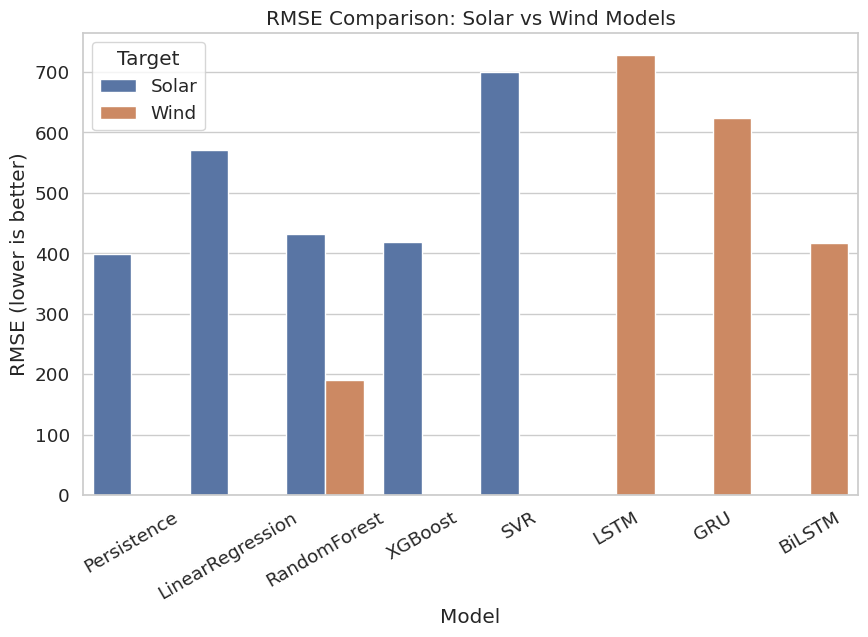

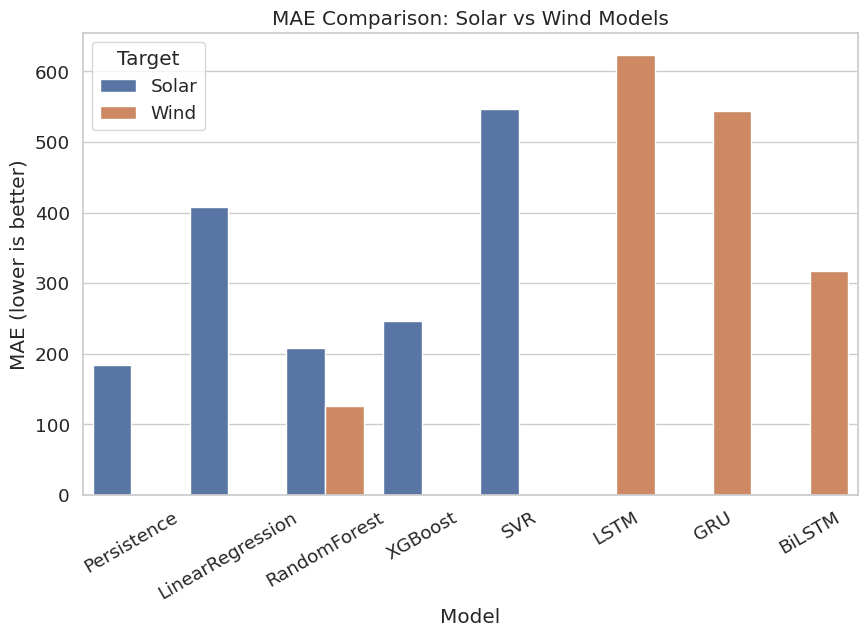

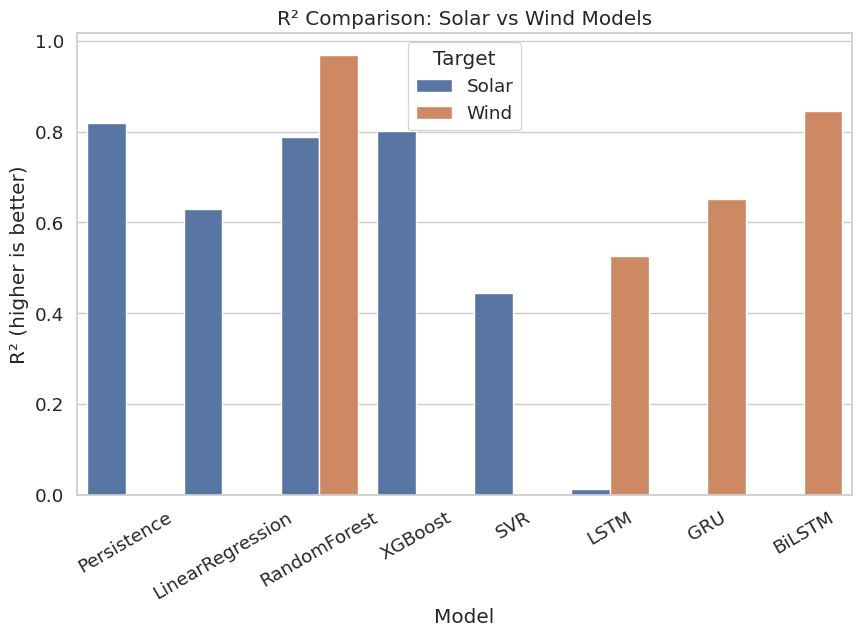

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid", font_scale=1.2)

# Plot RMSE comparison
plt.figure(figsize=(10,6))
sns.barplot(
    data=final_results,
    x="Model",
    y="RMSE",
    hue="Target"
)
plt.title("RMSE Comparison: Solar vs Wind Models")
plt.ylabel("RMSE (lower is better)")
plt.xticks(rotation=30)
plt.legend(title="Target")
plt.show()

# Plot MAE comparison
plt.figure(figsize=(10,6))
sns.barplot(
    data=final_results,
    x="Model",
    y="MAE",
    hue="Target"
)
plt.title("MAE Comparison: Solar vs Wind Models")
plt.ylabel("MAE (lower is better)")
plt.xticks(rotation=30)
plt.legend(title="Target")
plt.show()

# Plot R² comparison
plt.figure(figsize=(10,6))
sns.barplot(
    data=final_results,
    x="Model",
    y="R2",
    hue="Target"
)
plt.title("R² Comparison: Solar vs Wind Models")
plt.ylabel("R² (higher is better)")
plt.xticks(rotation=30)
plt.legend(title="Target")
plt.show()

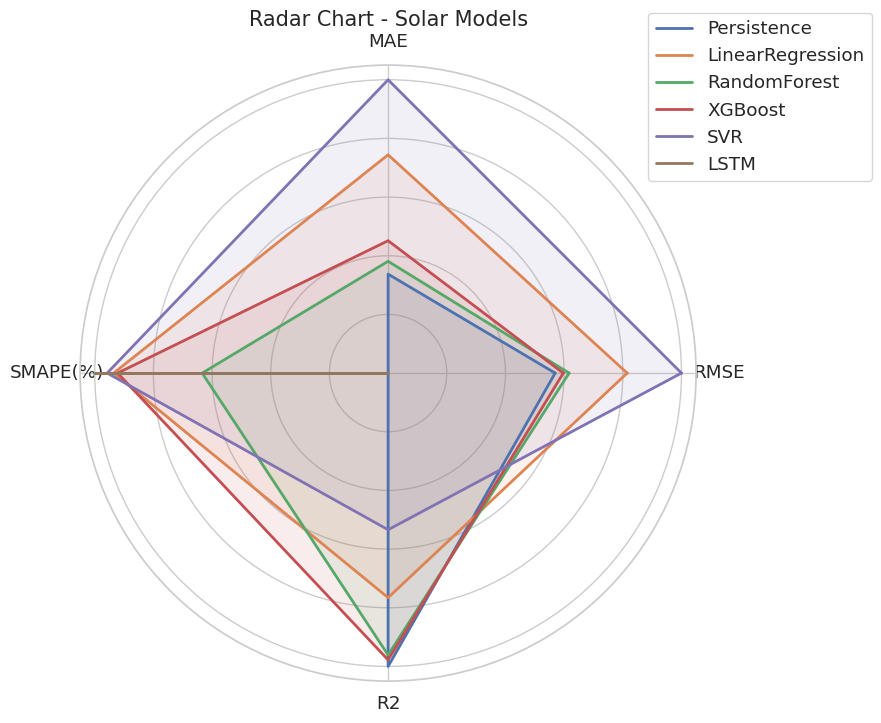

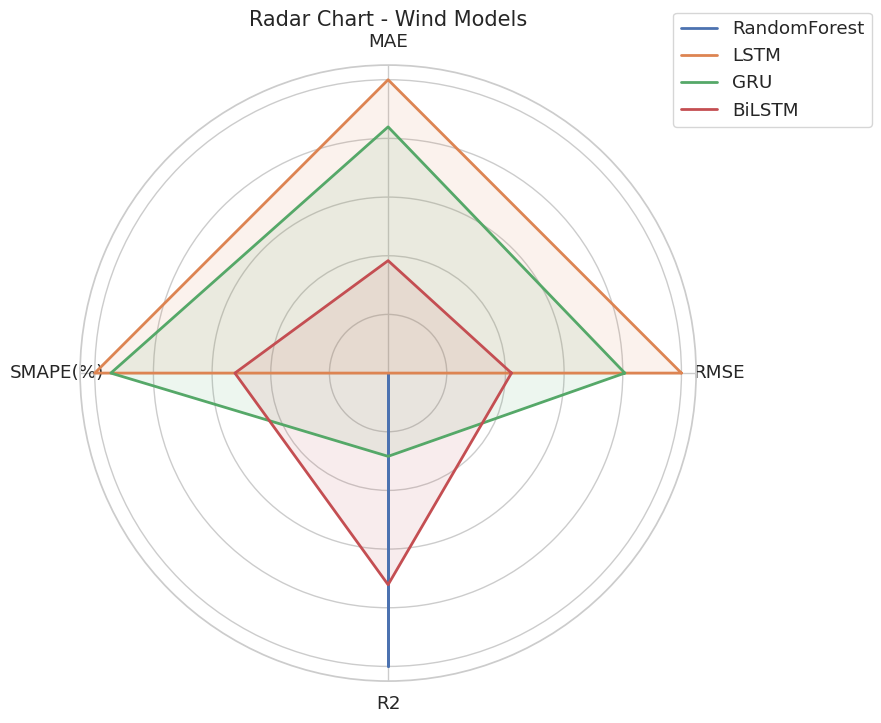

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Normalize metrics so they fit on same radar scale
def normalize(series):
    return (series - series.min()) / (series.max() - series.min() + 1e-8)

# Select metrics
metrics = ["RMSE", "MAE", "SMAPE(%)", "R2"]

# Prepare radar data
radar_data = final_results.copy()
radar_data[metrics] = radar_data.groupby("Target")[metrics].transform(normalize)

# Radar plot function
def plot_radar(df, target, title):
    labels = metrics
    num_vars = len(labels)

    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # complete loop

    plt.figure(figsize=(8,8))
    ax = plt.subplot(111, polar=True)

    for _, row in df[df["Target"]==target].iterrows():
        values = row[labels].tolist()
        values += values[:1]
        ax.plot(angles, values, label=row["Model"], linewidth=2)
        ax.fill(angles, values, alpha=0.1)

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    ax.set_yticklabels([])
    plt.title(title, size=15, y=1.05)
    plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
    plt.show()

# Plot radar charts for Solar and Wind separately
plot_radar(radar_data, target="Solar", title="Radar Chart - Solar Models")
plot_radar(radar_data, target="Wind", title="Radar Chart - Wind Models")

In [105]:
# ---------- Helpers to create sequences with index mapping ----------
import numpy as np
import pandas as pd

def create_sequences_with_index(X_df, y_arr, window):
    """
    Build sequences and return their corresponding target indices
    relative to X_df (0..len(X_df)-1). Useful to map predictions back
    to DateTime.
    """
    X = X_df.values
    y = np.array(y_arr)
    n = len(X)
    Xs, ys, idxs = [], [], []
    for i in range(n - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
        idxs.append(i + window)   # index in X_df corresponding to this target
    return np.array(Xs), np.array(ys), np.array(idxs)

# Explanation:
# - X_df is full scaled features (train+val+test concatenated, in original chronological order).
# - idxs gives the row index in X_df that corresponds to the prediction target (so we can map back to DateTime).

# ---------- Build the full scaled arrays (must replicate exactly how you built them earlier) ----------
# X_train_s, X_val_s, X_test_s are scaled DataFrames (MinMax or Standard), in time order.
X_scaled_full = pd.concat([X_train_s, X_val_s, X_test_s]).reset_index(drop=True)
y_scaled_full = np.concatenate([y_train_s_scaled, y_val_s_scaled, y_test_s_scaled])

# Choose window (same you used in training DL)
window = 24

# create sequences + indices
X_seq_full, y_seq_full, seq_idxs = create_sequences_with_index(X_scaled_full, y_scaled_full, window)

# Identify which sequence samples lie inside the *test* region.
n_train = len(X_train_s)
n_val   = len(X_val_s)
n_test  = len(X_test_s)
test_region_start = n_train + n_val    # first index in X_scaled_full that belongs to test set

# test sequence positions have idx >= test_region_start and idx < test_region_start + n_test
test_mask = (seq_idxs >= test_region_start) & (seq_idxs < test_region_start + n_test)
X_test_seq = X_seq_full[test_mask]
seq_test_idxs = seq_idxs[test_mask]    # these are indices (in X_scaled_full) of target times within the test set

print("Total sequence samples:", len(X_seq_full))
print("Test sequence samples:", len(X_test_seq))

Total sequence samples: 8703
Test sequence samples: 1310


In [107]:
# LSTM
y_pred_lstm_scaled = model_lstm.predict(X_test_seq).reshape(-1, 1)
y_pred_lstm_unscaled = target_scaler.inverse_transform(y_pred_lstm_scaled).flatten()

# GRU
y_pred_gru_scaled = model_gru.predict(X_test_seq).reshape(-1, 1)
y_pred_gru_unscaled = target_scaler.inverse_transform(y_pred_gru_scaled).flatten()

# BiLSTM
y_pred_bilstm_scaled = model_bilstm.predict(X_test_seq).reshape(-1, 1)
y_pred_bilstm_unscaled = target_scaler.inverse_transform(y_pred_bilstm_scaled).flatten()

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


In [108]:
# seq_test_idxs must be the indices for y_test_seq (sequence targets)
seq_test_dates = df['DateTime'].iloc[seq_test_idxs].reset_index(drop=True)

# DataFrame with DL predictions
df_seq_preds = pd.DataFrame({
    "DateTime": seq_test_dates,
    "LSTM_pred": y_pred_lstm_unscaled,
    "GRU_pred": y_pred_gru_unscaled,
    "BiLSTM_pred": y_pred_bilstm_unscaled
})

In [73]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Safe MAPE (handles zeros)
def mape_pct(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    mask = y_true != 0
    if mask.sum() == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100.0

# Unified evaluation
def eval_metrics(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    mape = mape_pct(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    return {"RMSE": rmse, "MAE": mae, "MAPE(%)": mape, "R2": r2}

# Example: compute for the models you have
results = []
results.append({"model": "Persistence", **eval_metrics(y_test_s, y_pred_persist)})
results.append({"model": "LinearRegression", **eval_metrics(y_test_s, y_pred_lr)})
results.append({"model": "RandomForest", **eval_metrics(y_test_s, y_pred_rf)})
results.append({"model": "XGBoost", **eval_metrics(y_test_s, y_pred_xgb_opt)})
# add LSTM if available
# results.append({"model":"LSTM", **eval_metrics(y_test_seq_truth, y_pred_lstm_unscaled)})

results_df = pd.DataFrame(results).sort_values("RMSE").reset_index(drop=True)
print(results_df)
# Save
results_df.to_csv("model_metrics_test.csv", index=False)

              model        RMSE         MAE     MAPE(%)        R2
0       Persistence  398.815722  184.756474  147.365187  0.819439
1           XGBoost  399.554119  221.257323  316.345847  0.818770
2      RandomForest  432.085592  208.695939  221.156343  0.788057
3  LinearRegression  570.667957  407.340272  369.656054  0.630302


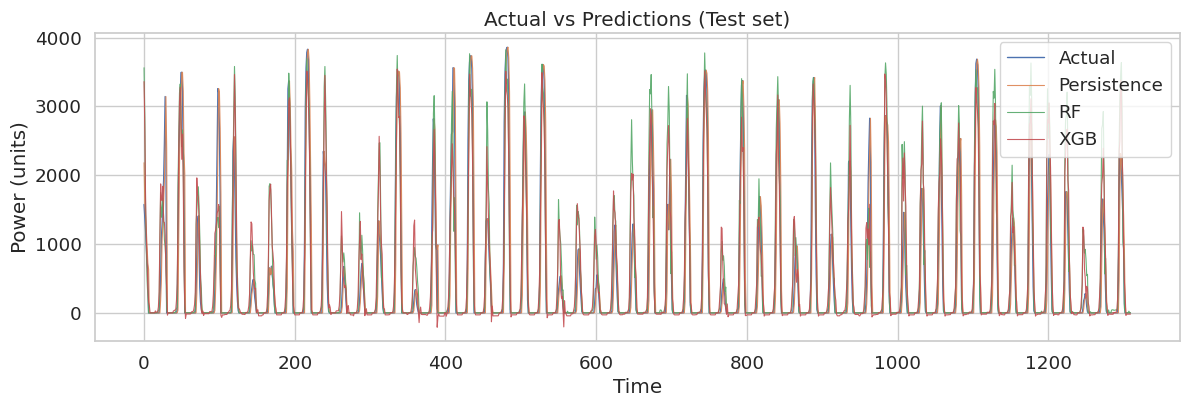

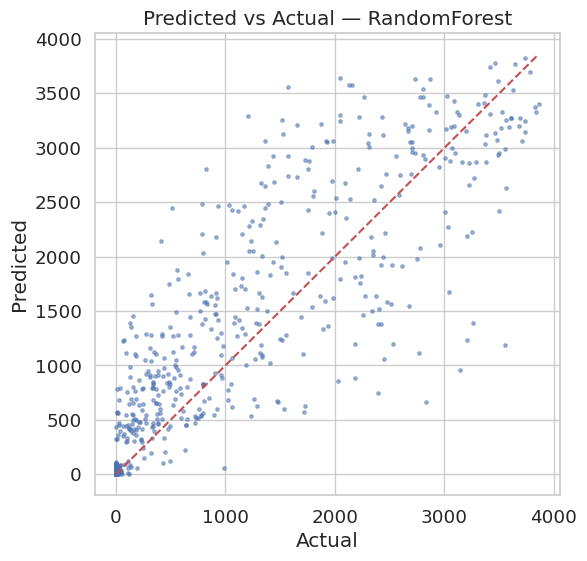

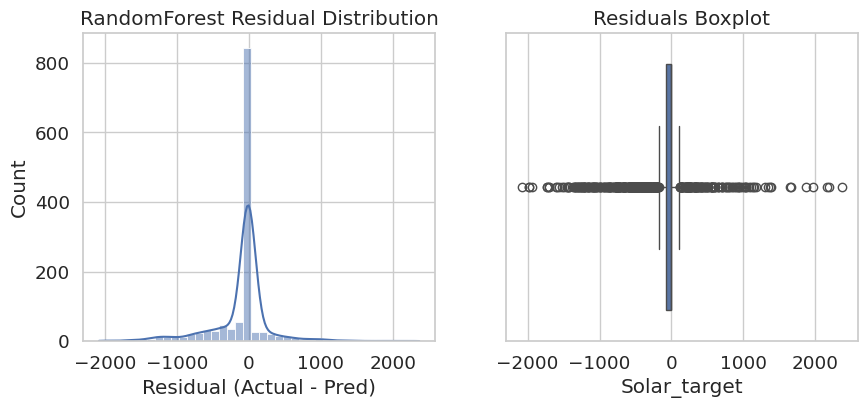

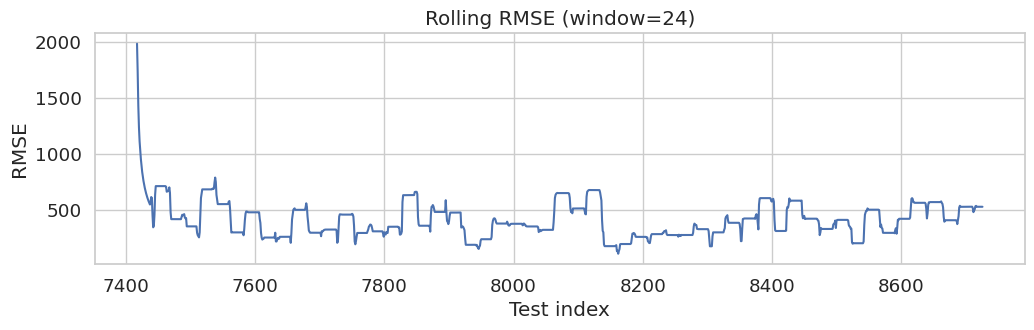

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

# 2.1 Time series: whole test period (or zoom)
def plot_series(y_true, preds_dict, index=None, n_zoom=200, save=None):
    """
    preds_dict: dict("ModelName": pred_array, ...)
    index: optional date index aligned with y_true/pred arrays (pandas Index)
    n_zoom: if index is None, plot first n_zoom points for readability
    """
    plt.figure(figsize=(14,4))
    if index is None:
        x = np.arange(len(y_true))
    else:
        x = index

    plt.plot(x, y_true, label="Actual", linewidth=1)
    for name, pred in preds_dict.items():
        plt.plot(x, pred, label=name, alpha=0.9, linewidth=0.8)
    plt.legend()
    plt.xlabel("Time")
    plt.ylabel("Power (units)")
    plt.title("Actual vs Predictions (Test set)")
    if save:
        plt.savefig(save, bbox_inches="tight")
    plt.show()

# Use it:
plot_series(y_test_s.values,
            {"Persistence": y_pred_persist.values,
             "RF": y_pred_rf,
             "XGB": y_pred_xgb_opt},
            index=None, n_zoom=300, save="pred_vs_actual.png")


# 2.2 Predicted vs Actual scatter
def scatter_pred_actual(y_true, y_pred, name="Model", save=None):
    plt.figure(figsize=(6,6))
    plt.scatter(y_true, y_pred, s=6, alpha=0.5)
    lim = [min(np.nanmin(y_true), np.nanmin(y_pred)), max(np.nanmax(y_true), np.nanmax(y_pred))]
    plt.plot(lim, lim, "r--")  # identity line
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.title(f"Predicted vs Actual — {name}")
    if save:
        plt.savefig(save, bbox_inches="tight")
    plt.show()

scatter_pred_actual(y_test_s, y_pred_rf, "RandomForest", save="scatter_rf.png")


# 2.3 Residuals histogram + KDE
def residual_plots(y_true, y_pred, name="Model", save_prefix=None):
    res = y_true - y_pred
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    sns.histplot(res, kde=True, bins=40)
    plt.title(f"{name} Residual Distribution")
    plt.xlabel("Residual (Actual - Pred)")
    plt.subplot(1,2,2)
    sns.boxplot(x=res)
    plt.title("Residuals Boxplot")
    if save_prefix:
        plt.savefig(save_prefix + "_residuals.png", bbox_inches="tight")
    plt.show()

residual_plots(y_test_s, y_pred_rf, "RandomForest", save_prefix="rf")

# 2.4 Rolling RMSE (window in samples, e.g., 24 for hourly)
def rolling_rmse(y_true, y_pred, window=24, save=None):
    err2 = (y_true - y_pred)**2
    rmse_roll = np.sqrt(pd.Series(err2).rolling(window=window, min_periods=1).mean())
    plt.figure(figsize=(12,3))
    plt.plot(rmse_roll)
    plt.title(f"Rolling RMSE (window={window})")
    plt.xlabel("Test index")
    plt.ylabel("RMSE")
    if save:
        plt.savefig(save, bbox_inches="tight")
    plt.show()
    return rmse_roll

rmse_roll_rf = rolling_rmse(y_test_s, y_pred_rf, window=24, save="rolling_rmse_rf.png")

In [77]:
import numpy as np
from scipy import stats

def diebold_mariano(y_true, y_pred1, y_pred2, h=1, loss="squared", alternative="two-sided"):
    """
    Diebold-Mariano test for equal forecast accuracy.
    y_true: true series (1d array)
    y_pred1, y_pred2: predicted series from model1 and model2 (aligned)
    h: forecast horizon (1 for 1-step)
    loss: "squared" or "absolute" (squared -> SE, absolute -> AE)
    alternative: "two-sided" or "less" or "greater"
    Returns: dm_stat, p_value
    """
    y_true = np.asarray(y_true)
    e1 = y_true - np.asarray(y_pred1)
    e2 = y_true - np.asarray(y_pred2)

    if loss == "squared":
        l1 = e1**2
        l2 = e2**2
    elif loss == "absolute":
        l1 = np.abs(e1)
        l2 = np.abs(e2)
    else:
        raise ValueError("loss must be 'squared' or 'absolute'")

    d = l1 - l2  # loss differential: positive => model1 worse
    T = len(d)
    dbar = np.mean(d)

    # compute autocovariances gamma_k for k=0..h-1
    def acov(x, lag):
        x = np.asarray(x)
        n = len(x)
        return np.sum((x[lag:] - x.mean()) * (x[:n-lag] - x.mean())) / n

    gamma = [acov(d, k) for k in range(1, h)]
    gamma0 = acov(d, 0)

    # long-run variance estimate (Diebold-Mariano)
    lr_var = (gamma0 + 2 * np.sum(gamma)) / T

    if lr_var <= 0:
        # fallback: use variance of d / T (not ideal)
        lr_var = np.var(d, ddof=1) / T

    dm_stat = dbar / np.sqrt(lr_var)

    # small sample correction (Harvey et al., optional) — comment/uncomment as needed
    # correction = np.sqrt((T + 1 - 2*h + (h*(h-1))/T))
    # dm_stat = dm_stat * correction

    # p-value from normal approximation
    if alternative == "two-sided":
        pval = 2 * (1 - stats.norm.cdf(np.abs(dm_stat)))
    elif alternative == "less":
        pval = stats.norm.cdf(dm_stat)
    elif alternative == "greater":
        pval = 1 - stats.norm.cdf(dm_stat)
    else:
        raise ValueError("alternative must be 'two-sided','less','greater'")

    return dm_stat, pval

# Example: compare RF vs XGB on test set, squared loss
dm_stat, pval = diebold_mariano(y_test_s, y_pred_rf, y_pred_xgb_opt, h=1, loss="squared")
print("DM statistic:", dm_stat, "p-value:", pval)

DM statistic: 3.3629354308493182 p-value: 0.0007711839924400277


In [79]:
import numpy as np

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def bootstrap_metric_diff(y_true, y_pred1, y_pred2, metric_func, n_boot=2000, seed=42, alpha=0.05):
    """
    Returns mean difference and percentile CI for metric1 - metric2.
    """
    rng = np.random.RandomState(seed)
    n = len(y_true)
    diffs = np.empty(n_boot)
    for i in range(n_boot):
        idx = rng.randint(0, n, size=n)   # sample with replacement
        m1 = metric_func(y_true[idx], y_pred1[idx])
        m2 = metric_func(y_true[idx], y_pred2[idx])
        diffs[i] = m1 - m2
    lower = np.percentile(diffs, 100 * alpha/2)
    upper = np.percentile(diffs, 100 * (1 - alpha/2))
    return diffs.mean(), (lower, upper), diffs

# Example: difference RMSE(RF) - RMSE(XGB)
mean_diff, (lo, hi), diffs = bootstrap_metric_diff(np.array(y_test_s), np.array(y_pred_rf), np.array(y_pred_xgb_opt),
                                                  metric_func=rmse, n_boot=2000)
print(f"RMSE_diff_mean = {mean_diff:.3f}, 95% CI = ({lo:.3f}, {hi:.3f})")

RMSE_diff_mean = 32.462, 95% CI = (14.347, 50.543)


In [87]:
# --- Predictions dictionary ---
# ML models use y_test_s (standard test set)
# DL models use y_test_seq (sequence test set)

preds_solar = {
    "Persistence": y_pred_persist,
    "LinearRegression": y_pred_lr,
    "RandomForest": y_pred_rf,
    "XGBoost": y_pred_xgb_opt,
    "SVR": y_pred_svr,
    "LSTM": y_pred_lstm,
    "GRU": y_pred_gru,
    "BiLSTM": y_pred_bilstm
}

# --- DM Test ---
models = list(preds_solar.keys())
pairs = []
pvals = []

for i in range(len(models)):
    for j in range(i+1, len(models)):
        m1, m2 = models[i], models[j]

        # ✅ Pick correct ground truth
        if (m1 in ["LSTM", "GRU", "BiLSTM"]) or (m2 in ["LSTM", "GRU", "BiLSTM"]):
            y_true = np.asarray(y_test_seq)  # DL truth
        else:
            y_true = np.asarray(y_test_s)    # ML truth

        y1 = np.asarray(preds_solar[m1])
        y2 = np.asarray(preds_solar[m2])

        # ✅ Align lengths (handle mismatch: ML=1310 vs DL=1306, etc.)
        min_len = min(len(y_true), len(y1), len(y2))
        y_true_aligned = y_true[-min_len:]
        y1_aligned = y1[-min_len:]
        y2_aligned = y2[-min_len:]

        # Run DM test
        dm_stat, pval = diebold_mariano(y_true_aligned, y1_aligned, y2_aligned, h=1, loss="squared")
        pairs.append(f"{m1} vs {m2}")
        pvals.append(pval)

# --- Multiple testing correction ---
pvals = np.array(pvals)

# Bonferroni correction
p_bonf = np.minimum(pvals * len(pvals), 1.0)

# Holm correction
def holm_correction(pvals):
    pvals = np.array(pvals)
    idx = np.argsort(pvals)
    m = len(pvals)
    adj = np.empty(m)
    for rank, k in enumerate(idx, start=1):
        adj[k] = min((m - rank + 1) * pvals[k], 1.0)
    return adj

p_holm = holm_correction(pvals)

# --- Results DataFrame ---
dm_results_solar = pd.DataFrame({
    "Comparison": pairs,
    "p_raw": pvals,
    "p_bonf": p_bonf,
    "p_holm": p_holm
}).sort_values("p_raw")

print(dm_results_solar)
dm_results_solar.to_csv("dm_results_solar.csv", index=False)

                          Comparison         p_raw        p_bonf        p_holm
0    Persistence vs LinearRegression  0.000000e+00  0.000000e+00  0.000000e+00
3                 Persistence vs SVR  0.000000e+00  0.000000e+00  0.000000e+00
5                 Persistence vs GRU  0.000000e+00  0.000000e+00  0.000000e+00
4                Persistence vs LSTM  0.000000e+00  0.000000e+00  0.000000e+00
6              Persistence vs BiLSTM  0.000000e+00  0.000000e+00  0.000000e+00
10          LinearRegression vs LSTM  0.000000e+00  0.000000e+00  0.000000e+00
9            LinearRegression vs SVR  0.000000e+00  0.000000e+00  0.000000e+00
8        LinearRegression vs XGBoost  0.000000e+00  0.000000e+00  0.000000e+00
12        LinearRegression vs BiLSTM  0.000000e+00  0.000000e+00  0.000000e+00
14               RandomForest vs SVR  0.000000e+00  0.000000e+00  0.000000e+00
15              RandomForest vs LSTM  0.000000e+00  0.000000e+00  0.000000e+00
11           LinearRegression vs GRU  0.000000e+00  

In [89]:
# --- Final summary of Phase D (Solar example) ---

# 1. Print metrics table
print("=== Metrics Summary ===")
print(results_df)

# 2. Print DM results (significance tests)
print("\n=== Diebold-Mariano Test Results ===")
print(dm_results_solar)

# 3. (Optional) Merge metrics + DM test for report
summary = {
    "metrics": results_df,
    "dm_results": dm_results_solar
}

# Save both to CSV/Excel for reporting
results_df.to_csv("solar_model_metrics.csv", index=False)
dm_results_solar.to_csv("solar_dm_results.csv", index=False)

print("\n✅ Phase D evaluation completed. Results saved for reporting.")

=== Metrics Summary ===
              model        RMSE         MAE     MAPE(%)        R2
0       Persistence  398.815722  184.756474  147.365187  0.819439
1           XGBoost  399.554119  221.257323  316.345847  0.818770
2      RandomForest  432.085592  208.695939  221.156343  0.788057
3  LinearRegression  570.667957  407.340272  369.656054  0.630302

=== Diebold-Mariano Test Results ===
                          Comparison         p_raw        p_bonf        p_holm
0    Persistence vs LinearRegression  0.000000e+00  0.000000e+00  0.000000e+00
3                 Persistence vs SVR  0.000000e+00  0.000000e+00  0.000000e+00
5                 Persistence vs GRU  0.000000e+00  0.000000e+00  0.000000e+00
4                Persistence vs LSTM  0.000000e+00  0.000000e+00  0.000000e+00
6              Persistence vs BiLSTM  0.000000e+00  0.000000e+00  0.000000e+00
10          LinearRegression vs LSTM  0.000000e+00  0.000000e+00  0.000000e+00
9            LinearRegression vs SVR  0.000000e+00  0.0

In [91]:
# --- Cell 1: Metrics for Wind models ---

# Example: collect results (add more models if you trained them for wind)
results_wind = []
results_wind.append({"model": "RandomForest", **eval_metrics(y_test_w, y_pred_rf_w)})
results_wind.append({"model": "XGBoost", **eval_metrics(y_test_w, y_pred_xgb_w)})
results_wind.append({"model": "LSTM", **eval_metrics(y_test_w_seq, y_pred_lstm_w)})
results_wind.append({"model": "GRU", **eval_metrics(y_test_w_seq, y_pred_gru_w)})
results_wind.append({"model": "BiLSTM", **eval_metrics(y_test_w_seq, y_pred_bilstm_w)})

# Convert to DataFrame
results_wind_df = pd.DataFrame(results_wind).sort_values("RMSE").reset_index(drop=True)
print(results_wind_df)

# Save for reporting
results_wind_df.to_csv("wind_model_metrics.csv", index=False)

          model        RMSE         MAE       MAPE(%)        R2
0        BiLSTM    0.083963    0.063932   4192.784941  0.845137
1           GRU    0.125912    0.109603  11900.971551  0.651733
2          LSTM    0.146848    0.125693  11939.305858  0.526294
3  RandomForest  189.949883  126.597329    681.495565  0.968287
4       XGBoost  196.864407  135.755066   1742.255846  0.965937


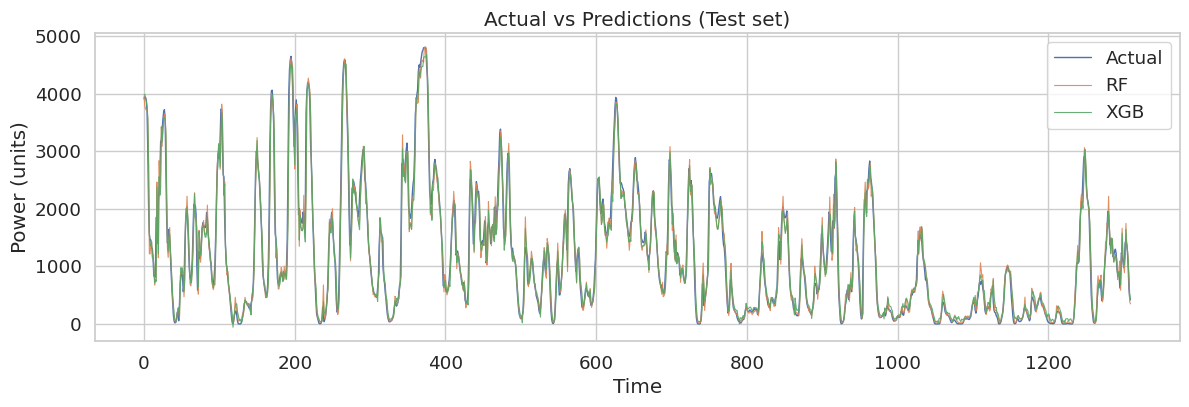

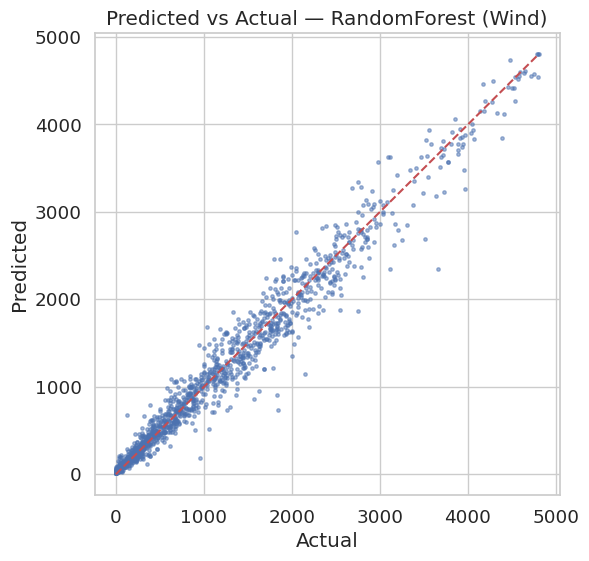

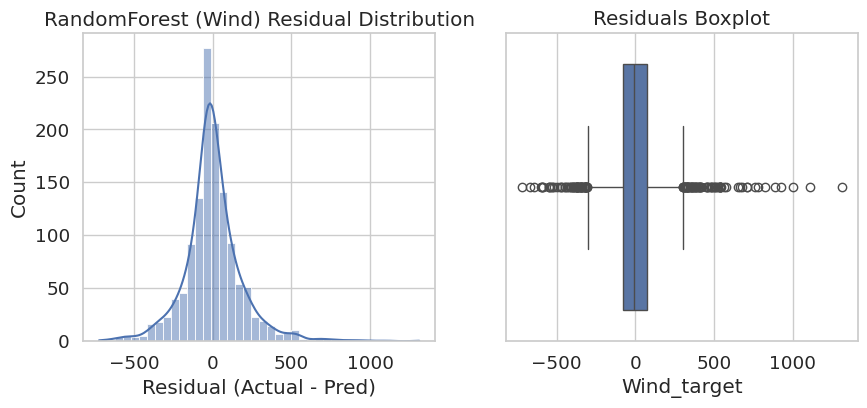

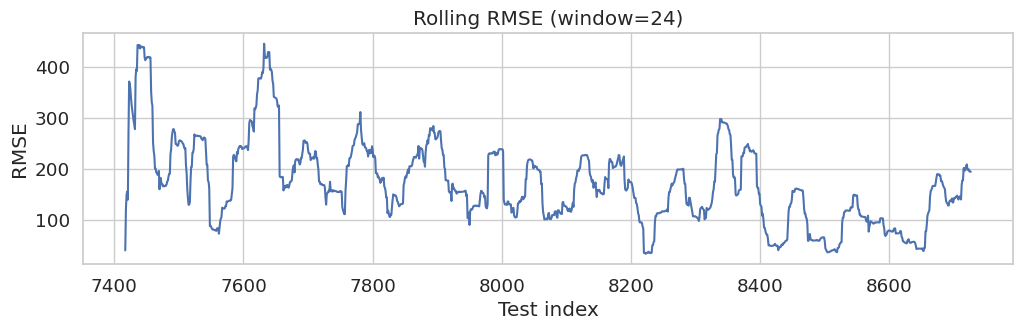

In [92]:
# --- Cell 2: Visualizations for Wind ---

# 2.1 Time series: Actual vs Predictions
plot_series(y_test_w.values,
            {"RF": y_pred_rf_w,
             "XGB": y_pred_xgb_w},
            index=None, n_zoom=300, save="wind_pred_vs_actual.png")

# 2.2 Scatter: Predicted vs Actual (RandomForest as example)
scatter_pred_actual(y_test_w, y_pred_rf_w, "RandomForest (Wind)", save="wind_scatter_rf.png")

# 2.3 Residuals distribution
residual_plots(y_test_w, y_pred_rf_w, "RandomForest (Wind)", save_prefix="wind_rf")

# 2.4 Rolling RMSE
rmse_roll_rf_w = rolling_rmse(y_test_w, y_pred_rf_w, window=24, save="wind_rolling_rmse_rf.png")

In [93]:
# --- Cell 3: Diebold-Mariano test for Wind ---

# Example: RF vs XGB
dm_stat_w, pval_w = diebold_mariano(y_test_w, y_pred_rf_w, y_pred_xgb_w, h=1, loss="squared")
print("Wind DM Test RF vs XGB -> DM stat:", dm_stat_w, "p-value:", pval_w)

Wind DM Test RF vs XGB -> DM stat: -2.4464118192222037 p-value: 0.014428608774708751


In [94]:
# --- Cell 4: Bootstrap CI for metric differences (Wind) ---

mean_diff_w, (lo_w, hi_w), diffs_w = bootstrap_metric_diff(
    np.array(y_test_w), np.array(y_pred_rf_w), np.array(y_pred_xgb_w),
    metric_func=rmse, n_boot=2000)

print(f"Wind RMSE_diff_mean = {mean_diff_w:.3f}, 95% CI = ({lo_w:.3f}, {hi_w:.3f})")

Wind RMSE_diff_mean = -6.835, 95% CI = (-12.447, -1.473)


In [101]:
for m1, m2 in [("RandomForest", "LSTM"), ("XGBoost", "GRU")]:
    y_true = np.array(y_test_s)  # or y_test_seq if DL
    y1 = np.array(preds_solar[m1])
    y2 = np.array(preds_solar[m2])

    min_len = min(len(y_true), len(y1), len(y2))
    y_true, y1, y2 = y_true[-min_len:], y1[-min_len:], y2[-min_len:]

    print(f"{m1} vs {m2}")
    print("RMSE1:", np.sqrt(mean_squared_error(y_true, y1)))
    print("RMSE2:", np.sqrt(mean_squared_error(y_true, y2)))

RandomForest vs LSTM
RMSE1: 427.27635427477765
RMSE2: 1059.3453248984147
XGBoost vs GRU
RMSE1: 395.31553252579846
RMSE2: 1242.2638756791175


In [96]:
# --- Cell 5: Full DM pairwise tests for Wind ---

preds_wind = {
    "RandomForest": y_pred_rf_w,
    "XGBoost": y_pred_xgb_w,
    "LSTM": y_pred_lstm_w,
    "GRU": y_pred_gru_w,
    "BiLSTM": y_pred_bilstm_w
}

models_w = list(preds_wind.keys())
pairs_w, pvals_w = [], []

for i in range(len(models_w)):
    for j in range(i+1, len(models_w)):
        m1, m2 = models_w[i], models_w[j]

        # Choose ground truth: DL vs ML alignment
        if (m1 in ["LSTM", "GRU", "BiLSTM"]) or (m2 in ["LSTM", "GRU", "BiLSTM"]):
            y_true = np.asarray(y_test_w_seq)
        else:
            y_true = np.asarray(y_test_w)

        y1 = np.asarray(preds_wind[m1])
        y2 = np.asarray(preds_wind[m2])

        # Align lengths
        min_len = min(len(y_true), len(y1), len(y2))
        y_true_aligned = y_true[-min_len:]
        y1_aligned = y1[-min_len:]
        y2_aligned = y2[-min_len:]

        # Run DM
        dm_stat, pval = diebold_mariano(y_true_aligned, y1_aligned, y2_aligned, h=1, loss="squared")
        pairs_w.append(f"{m1} vs {m2}")
        pvals_w.append(pval)

# Multiple testing correction
pvals_w = np.array(pvals_w)
p_bonf_w = np.minimum(pvals_w * len(pvals_w), 1.0)
p_holm_w = holm_correction(pvals_w)

dm_results_wind = pd.DataFrame({
    "Comparison": pairs_w,
    "p_raw": pvals_w,
    "p_bonf": p_bonf_w,
    "p_holm": p_holm_w
}).sort_values("p_raw")

print(dm_results_wind)
dm_results_wind.to_csv("dm_results_wind.csv", index=False)

                Comparison     p_raw    p_bonf    p_holm
1     RandomForest vs LSTM  0.000000  0.000000  0.000000
2      RandomForest vs GRU  0.000000  0.000000  0.000000
3   RandomForest vs BiLSTM  0.000000  0.000000  0.000000
4          XGBoost vs LSTM  0.000000  0.000000  0.000000
6        XGBoost vs BiLSTM  0.000000  0.000000  0.000000
5           XGBoost vs GRU  0.000000  0.000000  0.000000
7              LSTM vs GRU  0.000000  0.000000  0.000000
8           LSTM vs BiLSTM  0.000000  0.000000  0.000000
9            GRU vs BiLSTM  0.000000  0.000000  0.000000
0  RandomForest vs XGBoost  0.014429  0.144286  0.014429


In [97]:
# --- Cell 6: Final Wind summary ---

print("=== Wind Model Metrics ===")
print(results_wind_df)

print("\n=== Wind DM Test Results ===")
print(dm_results_wind)

# Save both
results_wind_df.to_csv("wind_model_metrics.csv", index=False)
dm_results_wind.to_csv("wind_dm_results.csv", index=False)

print("\n✅ Phase D Wind evaluation completed. Results saved for reporting.")

=== Wind Model Metrics ===
          model        RMSE         MAE       MAPE(%)        R2
0        BiLSTM    0.083963    0.063932   4192.784941  0.845137
1           GRU    0.125912    0.109603  11900.971551  0.651733
2          LSTM    0.146848    0.125693  11939.305858  0.526294
3  RandomForest  189.949883  126.597329    681.495565  0.968287
4       XGBoost  196.864407  135.755066   1742.255846  0.965937

=== Wind DM Test Results ===
                Comparison     p_raw    p_bonf    p_holm
1     RandomForest vs LSTM  0.000000  0.000000  0.000000
2      RandomForest vs GRU  0.000000  0.000000  0.000000
3   RandomForest vs BiLSTM  0.000000  0.000000  0.000000
4          XGBoost vs LSTM  0.000000  0.000000  0.000000
6        XGBoost vs BiLSTM  0.000000  0.000000  0.000000
5           XGBoost vs GRU  0.000000  0.000000  0.000000
7              LSTM vs GRU  0.000000  0.000000  0.000000
8           LSTM vs BiLSTM  0.000000  0.000000  0.000000
9            GRU vs BiLSTM  0.000000  0.000000

## **Final Results and Comparison**

In [98]:
# --- Cell 7: Merge Solar & Wind results into one table ---

# Add target column to each
df_solar_final = results_df.copy()
df_solar_final["Target"] = "Solar"

df_wind_final = results_wind_df.copy()
df_wind_final["Target"] = "Wind"

# Merge both
final_results = pd.concat([df_solar_final, df_wind_final], ignore_index=True)

# Reorder columns
final_results = final_results[["Target", "model", "RMSE", "MAE", "MAPE(%)", "R2"]]

print("=== Final Combined Results (Solar + Wind) ===")
print(final_results)

# Save
final_results.to_csv("final_results_solar_wind.csv", index=False)

=== Final Combined Results (Solar + Wind) ===
  Target             model        RMSE         MAE       MAPE(%)        R2
0  Solar       Persistence  398.815722  184.756474    147.365187  0.819439
1  Solar           XGBoost  399.554119  221.257323    316.345847  0.818770
2  Solar      RandomForest  432.085592  208.695939    221.156343  0.788057
3  Solar  LinearRegression  570.667957  407.340272    369.656054  0.630302
4   Wind            BiLSTM    0.083963    0.063932   4192.784941  0.845137
5   Wind               GRU    0.125912    0.109603  11900.971551  0.651733
6   Wind              LSTM    0.146848    0.125693  11939.305858  0.526294
7   Wind      RandomForest  189.949883  126.597329    681.495565  0.968287
8   Wind           XGBoost  196.864407  135.755066   1742.255846  0.965937


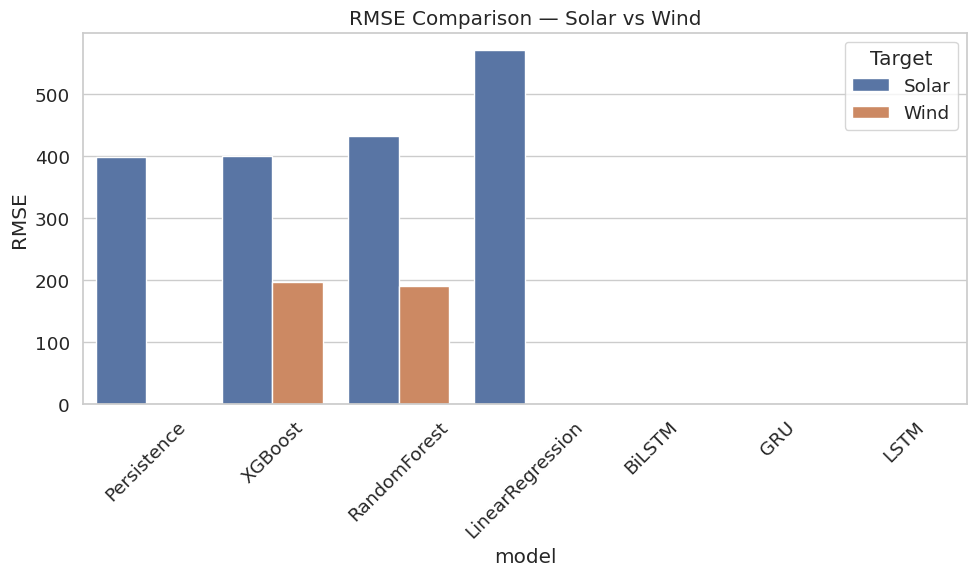

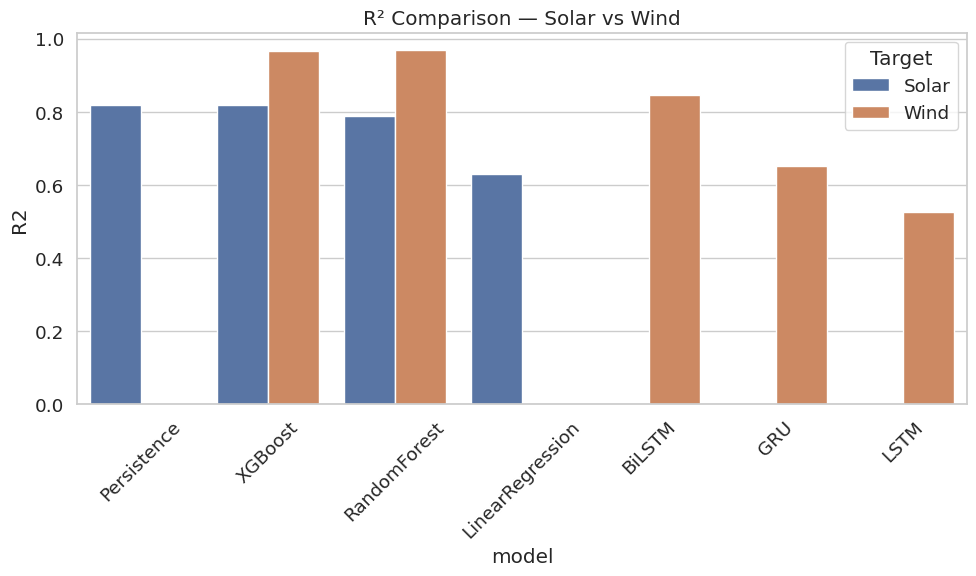

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt

# Barplot comparison of RMSE across Solar vs Wind
plt.figure(figsize=(10,6))
sns.barplot(data=final_results, x="model", y="RMSE", hue="Target")
plt.title("RMSE Comparison — Solar vs Wind")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("rmse_comparison_solar_wind.png", bbox_inches="tight")
plt.show()

# R² comparison
plt.figure(figsize=(10,6))
sns.barplot(data=final_results, x="model", y="R2", hue="Target")
plt.title("R² Comparison — Solar vs Wind")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("r2_comparison_solar_wind.png", bbox_inches="tight")
plt.show()

In [100]:
# --- Cell 9: Merge Solar + Wind DM test results ---

# Add target column
dm_results_solar_final = dm_results_solar.copy()
dm_results_solar_final["Target"] = "Solar"

dm_results_wind_final = dm_results_wind.copy()
dm_results_wind_final["Target"] = "Wind"

# Merge both
dm_results_all = pd.concat([dm_results_solar_final, dm_results_wind_final], ignore_index=True)

# Reorder for clarity
dm_results_all = dm_results_all[["Target", "Comparison", "p_raw", "p_bonf", "p_holm"]]

print("=== Final DM Results (Solar + Wind) ===")
print(dm_results_all)

# Save
dm_results_all.to_csv("dm_results_all.csv", index=False)

=== Final DM Results (Solar + Wind) ===
   Target                        Comparison         p_raw        p_bonf  \
0   Solar   Persistence vs LinearRegression  0.000000e+00  0.000000e+00   
1   Solar                Persistence vs SVR  0.000000e+00  0.000000e+00   
2   Solar                Persistence vs GRU  0.000000e+00  0.000000e+00   
3   Solar               Persistence vs LSTM  0.000000e+00  0.000000e+00   
4   Solar             Persistence vs BiLSTM  0.000000e+00  0.000000e+00   
5   Solar          LinearRegression vs LSTM  0.000000e+00  0.000000e+00   
6   Solar           LinearRegression vs SVR  0.000000e+00  0.000000e+00   
7   Solar       LinearRegression vs XGBoost  0.000000e+00  0.000000e+00   
8   Solar        LinearRegression vs BiLSTM  0.000000e+00  0.000000e+00   
9   Solar               RandomForest vs SVR  0.000000e+00  0.000000e+00   
10  Solar              RandomForest vs LSTM  0.000000e+00  0.000000e+00   
11  Solar           LinearRegression vs GRU  0.000000e+00  0

In [102]:
# ---------- Helpers to create sequences with index mapping ----------
import numpy as np
import pandas as pd

def create_sequences_with_index(X_df, y_arr, window):
    """
    Build sequences and return their corresponding target indices
    relative to X_df (0..len(X_df)-1). Useful to map predictions back
    to DateTime.
    """
    X = X_df.values
    y = np.array(y_arr)
    n = len(X)
    Xs, ys, idxs = [], [], []
    for i in range(n - window):
        Xs.append(X[i:i+window])
        ys.append(y[i+window])
        idxs.append(i + window)   # index in X_df corresponding to this target
    return np.array(Xs), np.array(ys), np.array(idxs)

# Explanation:
# - X_df is full scaled features (train+val+test concatenated, in original chronological order).
# - idxs gives the row index in X_df that corresponds to the prediction target (so we can map back to DateTime).

# ---------- Build the full scaled arrays (must replicate exactly how you built them earlier) ----------
# X_train_s, X_val_s, X_test_s are scaled DataFrames (MinMax or Standard), in time order.
X_scaled_full = pd.concat([X_train_s, X_val_s, X_test_s]).reset_index(drop=True)
y_scaled_full = np.concatenate([y_train_s_scaled, y_val_s_scaled, y_test_s_scaled])

# Choose window (same you used in training DL)
window = 24

# create sequences + indices
X_seq_full, y_seq_full, seq_idxs = create_sequences_with_index(X_scaled_full, y_scaled_full, window)

# Identify which sequence samples lie inside the *test* region.
n_train = len(X_train_s)
n_val   = len(X_val_s)
n_test  = len(X_test_s)
test_region_start = n_train + n_val    # first index in X_scaled_full that belongs to test set

# test sequence positions have idx >= test_region_start and idx < test_region_start + n_test
test_mask = (seq_idxs >= test_region_start) & (seq_idxs < test_region_start + n_test)
X_test_seq = X_seq_full[test_mask]
seq_test_idxs = seq_idxs[test_mask]    # these are indices (in X_scaled_full) of target times within the test set

print("Total sequence samples:", len(X_seq_full))
print("Test sequence samples:", len(X_test_seq))

Total sequence samples: 8703
Test sequence samples: 1310
